In [2]:
#!/usr/bin/env python3
"""
Condition-based Functional ROI Creation
Uses individual condition activations (face>all, word>all) to define ROI
Then extracts contrast (face-word) from these voxels
"""

import numpy as np
import nibabel as nib
from pathlib import Path
from scipy import ndimage
import matplotlib.pyplot as plt
from nilearn import plotting, surface

BASE_DIR = Path('/user_data/csimmon2/long_pt')

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-007': {'code': 'OT', 'sessions': ['01', '03', '04'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'}
}

def create_condition_based_roi(subject_id, roi_type='face_word', threshold=2.3):
    """
    Create ROI from condition activations (not contrasts)
    roi_type: 'face_word' or 'object_house'
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()}")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and copes based on roi_type
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num = 6  # face>all
        cope2_num = 9  # word>all
        cope_names = ['face', 'word']
    else:  # object_house
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num = 8  # object>all
        cope2_num = 7  # house>all
        cope_names = ['object', 'house']
    
    # Load anatomical constraint
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load condition activations
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # Create functional mask: responsive to EITHER condition
    functional_mask = ((cope1_data > threshold) | (cope2_data > threshold)) & anat_mask
    
    # Get largest cluster only
    labeled, n_clusters = ndimage.label(functional_mask)
    
    if n_clusters > 0:
        cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
        largest_idx = np.argmax(cluster_sizes) + 1
        functional_mask = (labeled == largest_idx)
        
        n_voxels = cluster_sizes[largest_idx - 1]
        print(f"Found {n_clusters} clusters, keeping largest: {n_voxels} voxels")
    else:
        n_voxels = 0
        print("No clusters found!")
    
    # Get center of mass
    if n_voxels > 0:
        coords = np.where(functional_mask)
        center_vox = [np.mean(c) for c in coords]
        center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
        print(f"Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save functional ROI
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_condition_based.nii.gz'
    functional_img = nib.Nifti1Image(functional_mask.astype(np.float32), anat_roi.affine)
    nib.save(functional_img, output_file)
    print(f"Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_voxels': n_voxels,
        'cope1_img': cope1_img,
        'cope2_img': cope2_img,
        'functional_mask': functional_mask,
        'anat_roi': anat_roi
    }

# Create ROIs for all subjects
roi_results = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results[subject_id] = {}
    roi_results[subject_id]['face_word'] = create_condition_based_roi(subject_id, 'face_word')
    roi_results[subject_id]['object_house'] = create_condition_based_roi(subject_id, 'object_house')


sub-004 - FACE_WORD
Found 18 clusters, keeping largest: 1057 voxels
Center: (-28.8, -33.2, -5.3)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_condition_based.nii.gz

sub-004 - OBJECT_HOUSE
Found 39 clusters, keeping largest: 2236 voxels
Center: (-38.3, -62.5, 6.7)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_condition_based.nii.gz

sub-021 - FACE_WORD
Found 13 clusters, keeping largest: 7900 voxels
Center: (32.7, -52.5, 1.1)
Saved: /user_data/csimmon2/long_pt/sub-021/ses-01/ROIs/r_face_word_condition_based.nii.gz

sub-021 - OBJECT_HOUSE
Found 14 clusters, keeping largest: 15677 voxels
Center: (27.4, -79.4, 16.2)
Saved: /user_data/csimmon2/long_pt/sub-021/ses-01/ROIs/r_object_house_condition_based.nii.gz


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/tmp/ipykernel_3286020/343351119.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


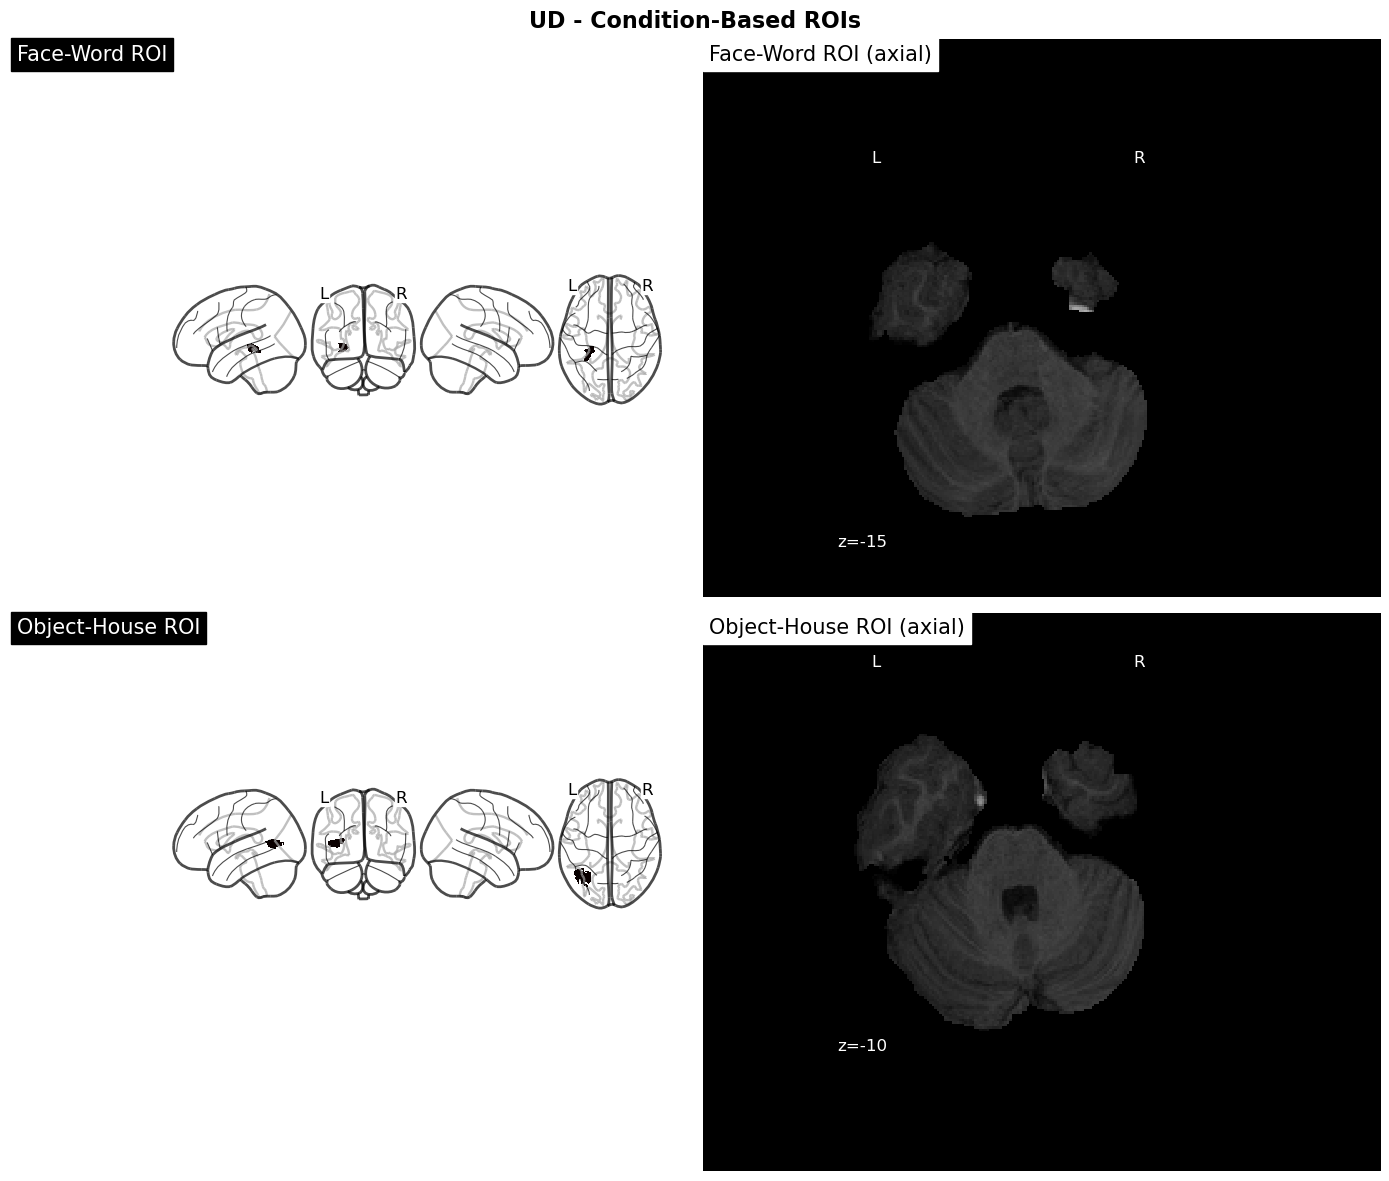

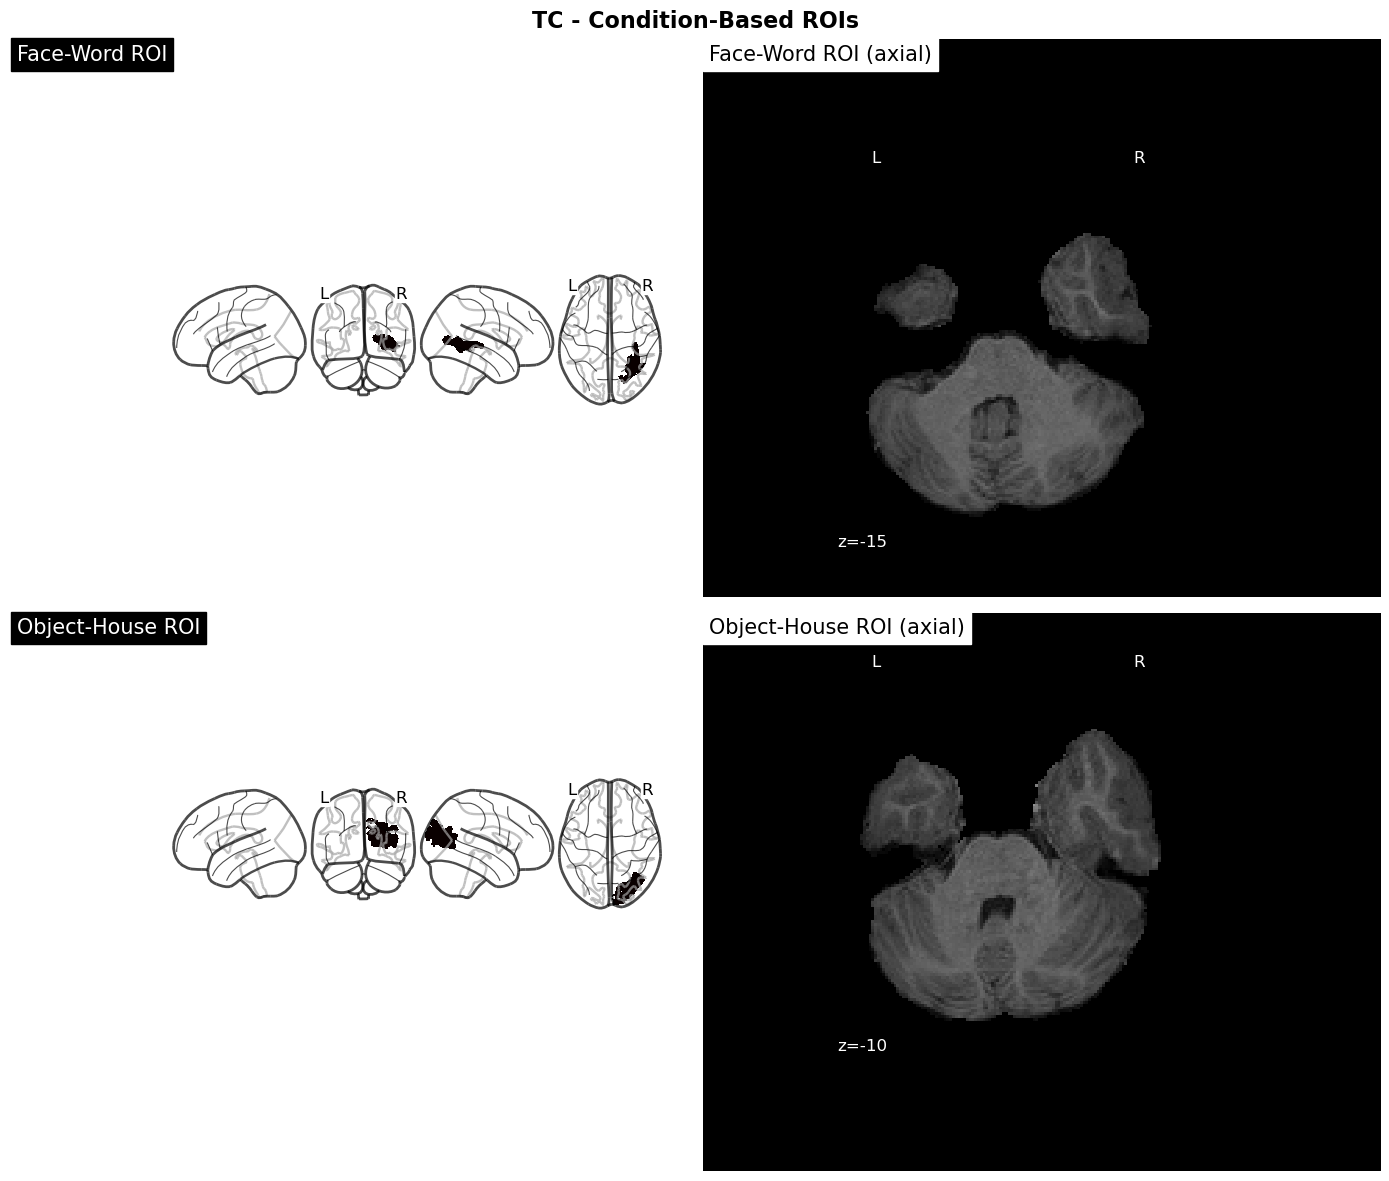

In [2]:
# VISUALIZATION 1: Glass brain showing ROI location

for subject_id in ['sub-004', 'sub-021']:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    
    # Face-word ROI
    fw_roi = roi_results[subject_id]['face_word']['mask_file']
    
    plotting.plot_glass_brain(
        fw_roi, axes=axes[0, 0], title='Face-Word ROI',
        display_mode='lyrz', colorbar=False, plot_abs=False
    )
    
    plotting.plot_roi(
        fw_roi, bg_img=anat_file, axes=axes[0, 1],
        title='Face-Word ROI (axial)', display_mode='z',
        cut_coords=[-15], alpha=0.7, cmap='Reds'
    )
    
    # Object-house ROI
    oh_roi = roi_results[subject_id]['object_house']['mask_file']
    
    plotting.plot_glass_brain(
        oh_roi, axes=axes[1, 0], title='Object-House ROI',
        display_mode='lyrz', colorbar=False, plot_abs=False
    )
    
    plotting.plot_roi(
        oh_roi, bg_img=anat_file, axes=axes[1, 1],
        title='Object-House ROI (axial)', display_mode='z',
        cut_coords=[-10], alpha=0.7, cmap='Blues'
    )
    
    fig.suptitle(f'{SUBJECTS[subject_id]["code"]} - Condition-Based ROIs', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_condition_rois_glass.png', dpi=150)
    plt.show()

/tmp/ipykernel_3286020/2982588698.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


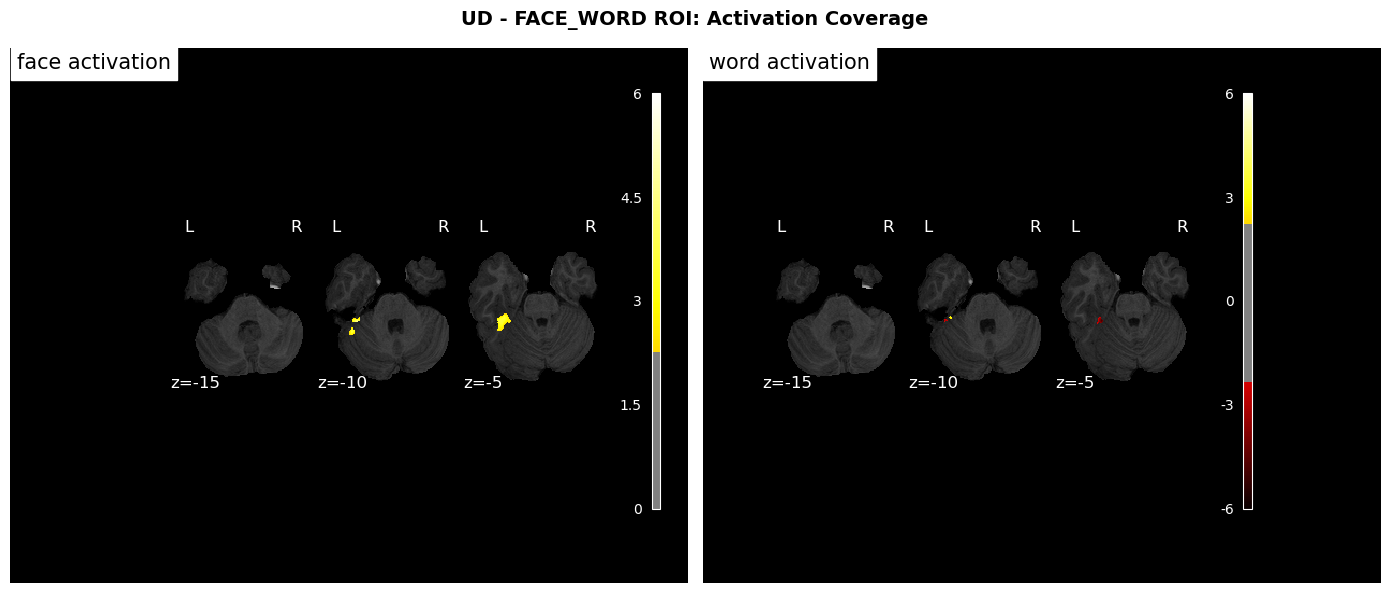

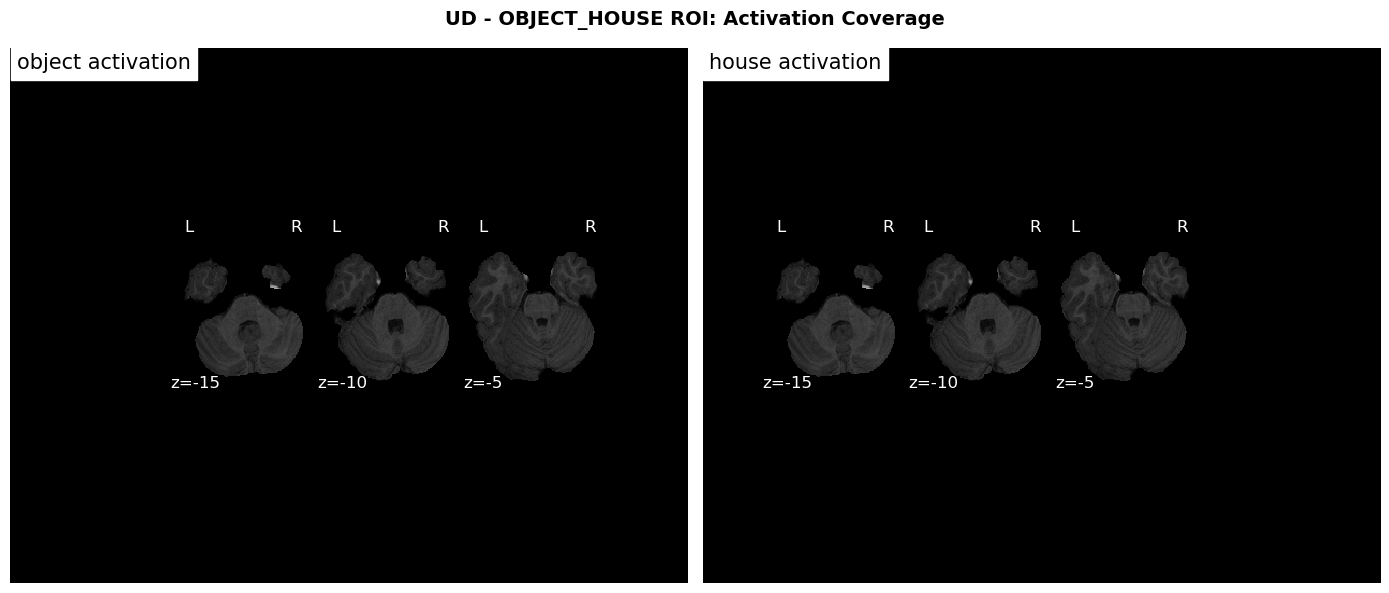

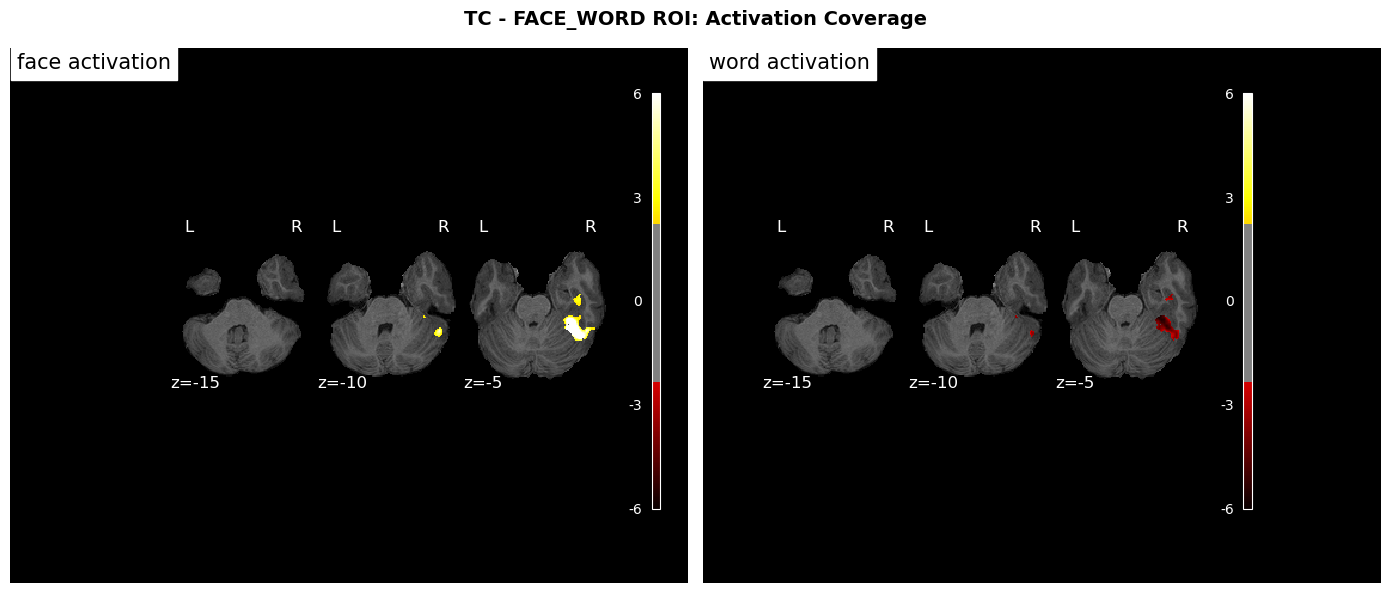

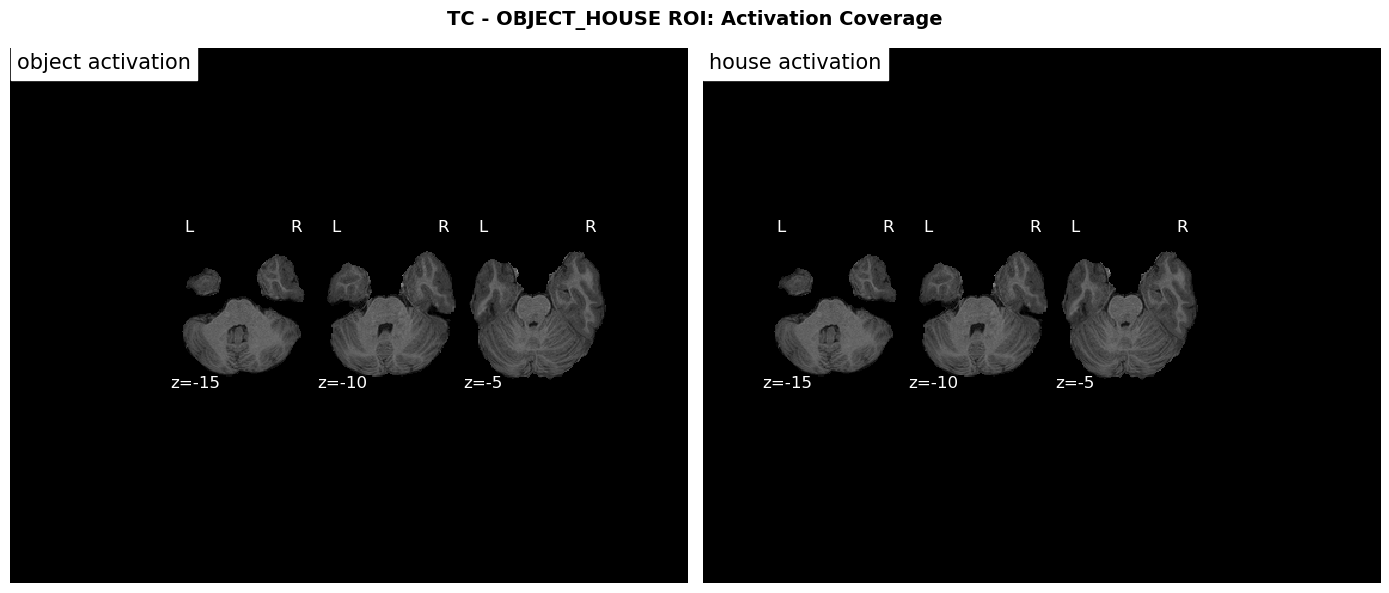

In [3]:
# VISUALIZATION 2: Show activation captured by ROI

for subject_id in ['sub-004', 'sub-021']:
    
    for roi_type in ['face_word', 'object_house']:
        
        result = roi_results[subject_id][roi_type]
        
        # Mask activations by ROI
        roi_mask = result['functional_mask']
        cope1_masked = result['cope1_img'].get_fdata() * roi_mask
        cope2_masked = result['cope2_img'].get_fdata() * roi_mask
        
        cope1_img_masked = nib.Nifti1Image(cope1_masked, result['cope1_img'].affine)
        cope2_img_masked = nib.Nifti1Image(cope2_masked, result['cope2_img'].affine)
        
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Cope 1
        plotting.plot_stat_map(
            cope1_img_masked, bg_img=anat_file, axes=axes[0],
            threshold=2.3, title=f'{roi_type.split("_")[0]} activation',
            display_mode='z', cut_coords=[-15, -10, -5],
            cmap='hot', vmax=6
        )
        
        # Cope 2
        plotting.plot_stat_map(
            cope2_img_masked, bg_img=anat_file, axes=axes[1],
            threshold=2.3, title=f'{roi_type.split("_")[1]} activation',
            display_mode='z', cut_coords=[-15, -10, -5],
            cmap='hot', vmax=6
        )
        
        fig.suptitle(f'{SUBJECTS[subject_id]["code"]} - {roi_type.upper()} ROI: Activation Coverage',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_{roi_type}_activation_coverage.png', dpi=150)
        plt.show()

In [15]:
def create_condition_based_roi_v2(subject_id, roi_type='face_word', 
                                   target_percentile=75, min_voxels=8000, max_voxels=15000):
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()}")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope2_num = 6, 9  # face, word
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope2_num = 8, 7  # object, house
    
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load conditions
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # OPTION: Use mean instead of max for balance
    # combined_activation = (cope1_data + cope2_data) / 2
    max_activation = np.maximum(cope1_data, cope2_data)
    
    # Get values within anatomical ROI
    roi_values = max_activation[anat_mask]
    
    # Initialize tracking BEFORE any thresholding
    threshold = np.percentile(roi_values, target_percentile)
    functional_mask = (max_activation > threshold) & anat_mask
    labeled, n_clusters = ndimage.label(functional_mask)
    
    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)] if n_clusters > 0 else [0]
    largest_idx = np.argmax(cluster_sizes) + 1 if n_clusters > 0 else 0
    initial_n_voxels = cluster_sizes[largest_idx - 1] if n_clusters > 0 else 0
    
    adjustment_log = {
        'initial_percentile': target_percentile,
        'initial_threshold': threshold,
        'initial_n_voxels': initial_n_voxels,
        'final_percentile': target_percentile,
        'final_threshold': threshold,
        'final_n_voxels': initial_n_voxels,
        'adjusted': False,
        'reason': None
    }
    
    # Now do adjustments
    if n_clusters > 0:
        functional_mask = (labeled == largest_idx)
        n_voxels = cluster_sizes[largest_idx - 1]
        
        print(f"Threshold: {threshold:.2f} ({target_percentile}th percentile)")
        print(f"Found {n_clusters} clusters, largest: {n_voxels} voxels")
        
        # Adjust if needed
        if n_voxels < min_voxels:
            adjustment_log['adjusted'] = True
            adjustment_log['reason'] = 'too_small'
            print(f"Too small, lowering threshold...")
            new_percentile = target_percentile - 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (max_activation > threshold) & anat_mask
            labeled, n_clusters = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile")
            
            adjustment_log['final_percentile'] = new_percentile
            adjustment_log['final_threshold'] = threshold
            adjustment_log['final_n_voxels'] = n_voxels
        
        elif n_voxels > max_voxels:
            adjustment_log['adjusted'] = True
            adjustment_log['reason'] = 'too_large'
            print(f"Too large, raising threshold...")
            new_percentile = target_percentile + 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (max_activation > threshold) & anat_mask
            labeled, n_clusters = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile")
            
            adjustment_log['final_percentile'] = new_percentile
            adjustment_log['final_threshold'] = threshold
            adjustment_log['final_n_voxels'] = n_voxels
        else:
            adjustment_log['final_n_voxels'] = n_voxels
    
    # Get center
    coords = np.where(functional_mask)
    center_vox = [np.mean(c) for c in coords]
    center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
    print(f"Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_percentile_based.nii.gz'
    functional_img = nib.Nifti1Image(functional_mask.astype(np.float32), anat_roi.affine)
    nib.save(functional_img, output_file)
    print(f"Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_voxels': n_voxels,
        'threshold': threshold,
        'adjustment_log': adjustment_log
    }

# Re-run with percentile approach
roi_results_v2 = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_v2[subject_id] = {}
    roi_results_v2[subject_id]['face_word'] = create_condition_based_roi_v2(subject_id, 'face_word')
    roi_results_v2[subject_id]['object_house'] = create_condition_based_roi_v2(subject_id, 'object_house')

# Check sizes
print("\n" + "="*60)
print("ROI Sizes (Percentile-Based)")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    print(f"  Face-Word: {roi_results_v2[subject_id]['face_word']['n_voxels']} voxels")
    print(f"  Object-House: {roi_results_v2[subject_id]['object_house']['n_voxels']} voxels")


sub-004 - FACE_WORD
Threshold: 0.89 (75th percentile)
Found 26 clusters, largest: 5089 voxels
Too small, lowering threshold...
Adjusted: 7308 voxels at 65th percentile
Center: (-31.2, -43.5, -2.3)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_percentile_based.nii.gz

sub-004 - OBJECT_HOUSE
Threshold: 1.97 (75th percentile)
Found 33 clusters, largest: 6515 voxels
Too small, lowering threshold...
Adjusted: 10289 voxels at 65th percentile
Center: (-29.3, -74.4, 11.1)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_percentile_based.nii.gz

sub-021 - FACE_WORD
Threshold: 5.53 (75th percentile)
Found 3 clusters, largest: 4476 voxels
Too small, lowering threshold...
Adjusted: 6230 voxels at 65th percentile
Center: (32.4, -53.1, 1.2)
Saved: /user_data/csimmon2/long_pt/sub-021/ses-01/ROIs/r_face_word_percentile_based.nii.gz

sub-021 - OBJECT_HOUSE
Threshold: 4.71 (75th percentile)
Found 9 clusters, largest: 6139 voxels
Too small, lowering threshold...


UD - ROI Composition

Face-Word ROI (7308 voxels):
  Face-selective: 1187 (16.2%)
  Word-selective: 121 (1.7%)
  Both active (z>2.3): 6 (0.1%)
  Mean face activation: 0.73
  Mean word activation: -0.58


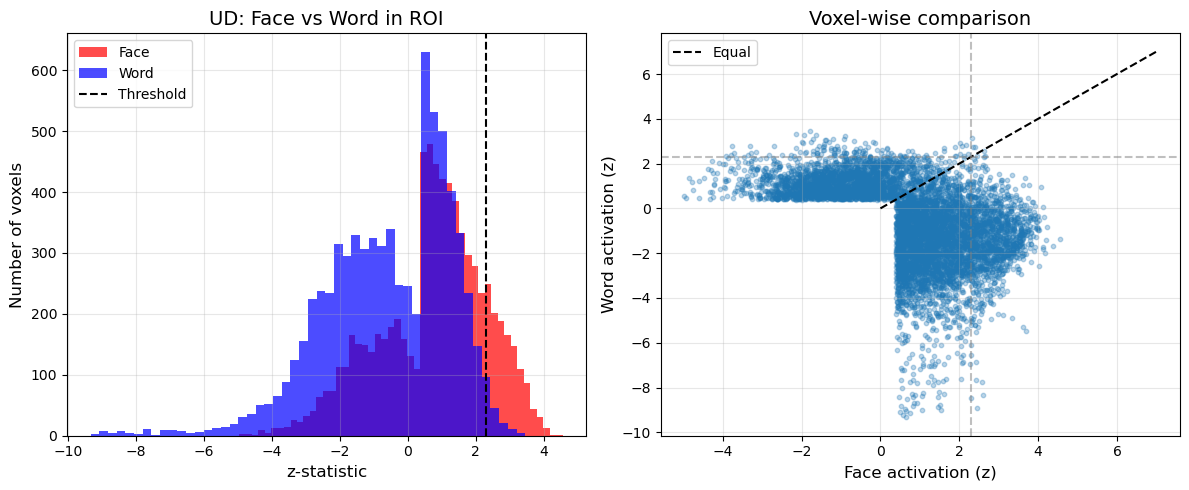


TC - ROI Composition

Face-Word ROI (6230 voxels):
  Face-selective: 6230 (100.0%)
  Word-selective: 0 (0.0%)
  Both active (z>2.3): 6 (0.1%)
  Mean face activation: 8.14
  Mean word activation: -3.59


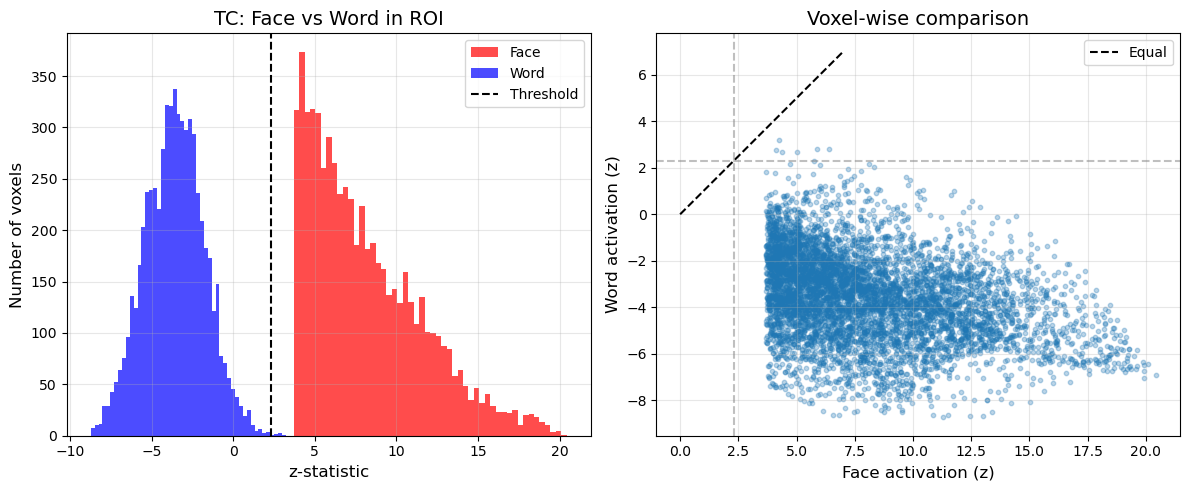

In [16]:
# Check face vs word dominance in final ROIs

for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{'='*60}")
    print(f"{SUBJECTS[subject_id]['code']} - ROI Composition")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load final face_word ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_word_percentile_based.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    
    # Load face and word activations
    face_img = nib.load(BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                        'HighLevel.gfeat' / 'cope6.feat' / 'stats' / 'zstat1.nii.gz')
    word_img = nib.load(BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                        'HighLevel.gfeat' / 'cope9.feat' / 'stats' / 'zstat1.nii.gz')
    
    face_data = face_img.get_fdata()[roi_mask]
    word_data = word_img.get_fdata()[roi_mask]
    
    # Categorize voxels
    face_selective = (face_data > word_data) & (face_data > 2.3)
    word_selective = (word_data > face_data) & (word_data > 2.3)
    both_active = (face_data > 2.3) & (word_data > 2.3)
    
    print(f"\nFace-Word ROI ({np.sum(roi_mask)} voxels):")
    print(f"  Face-selective: {np.sum(face_selective)} ({100*np.sum(face_selective)/len(face_data):.1f}%)")
    print(f"  Word-selective: {np.sum(word_selective)} ({100*np.sum(word_selective)/len(word_data):.1f}%)")
    print(f"  Both active (z>2.3): {np.sum(both_active)} ({100*np.sum(both_active)/len(face_data):.1f}%)")
    print(f"  Mean face activation: {face_data.mean():.2f}")
    print(f"  Mean word activation: {word_data.mean():.2f}")
    
    # Histogram comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].hist(face_data, bins=50, alpha=0.7, label='Face', color='red')
    axes[0].hist(word_data, bins=50, alpha=0.7, label='Word', color='blue')
    axes[0].axvline(2.3, color='black', linestyle='--', label='Threshold')
    axes[0].set_xlabel('z-statistic', fontsize=12)
    axes[0].set_ylabel('Number of voxels', fontsize=12)
    axes[0].set_title(f'{SUBJECTS[subject_id]["code"]}: Face vs Word in ROI', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot
    axes[1].scatter(face_data, word_data, alpha=0.3, s=10)
    axes[1].plot([0, 7], [0, 7], 'k--', label='Equal')
    axes[1].axhline(2.3, color='gray', linestyle='--', alpha=0.5)
    axes[1].axvline(2.3, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Face activation (z)', fontsize=12)
    axes[1].set_ylabel('Word activation (z)', fontsize=12)
    axes[1].set_title('Voxel-wise comparison', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_face_word_balance.png', dpi=150)
    plt.show()

In [13]:
def create_condition_based_roi_v2(subject_id, roi_type='face_word', 
                                   target_percentile=75, min_voxels=8000, max_voxels=15000):
    """
    Create ROI using percentile threshold within anatomical constraint
    Ensures more consistent sizes across subjects
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()}")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope2_num = 6, 9  # face, word
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope2_num = 8, 7  # object, house
    
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load conditions
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # Take maximum activation of the two conditions
    max_activation = np.maximum(cope1_data, cope2_data)
    
    # Get values within anatomical ROI
    roi_values = max_activation[anat_mask]
    
    # Use percentile to set threshold
    threshold = np.percentile(roi_values, target_percentile)
    
    functional_mask = (max_activation > threshold) & anat_mask
    
    # Find largest cluster
    labeled, n_clusters = ndimage.label(functional_mask)
    
    if n_clusters > 0:
        cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
        largest_idx = np.argmax(cluster_sizes) + 1
        functional_mask = (labeled == largest_idx)
        n_voxels = cluster_sizes[largest_idx - 1]
        
        print(f"Threshold: {threshold:.2f} ({target_percentile}th percentile)")
        print(f"Found {n_clusters} clusters, largest: {n_voxels} voxels")
        
        # Adjust if outside target range
        if n_voxels < min_voxels:
            print(f"Too small, lowering threshold...")
            new_percentile = target_percentile - 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (max_activation > threshold) & anat_mask
            labeled, _ = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile")
        
        elif n_voxels > max_voxels:
            print(f"Too large, raising threshold...")
            new_percentile = target_percentile + 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (max_activation > threshold) & anat_mask
            labeled, _ = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile")
    
    # Get center
    coords = np.where(functional_mask)
    center_vox = [np.mean(c) for c in coords]
    center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
    print(f"Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_percentile_based.nii.gz'
    functional_img = nib.Nifti1Image(functional_mask.astype(np.float32), anat_roi.affine)
    nib.save(functional_img, output_file)
    print(f"Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_voxels': n_voxels,
        'threshold': threshold
    }

# Re-run with percentile approach
roi_results_v2 = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_v2[subject_id] = {}
    roi_results_v2[subject_id]['face_word'] = create_condition_based_roi_v2(subject_id, 'face_word')
    roi_results_v2[subject_id]['object_house'] = create_condition_based_roi_v2(subject_id, 'object_house')

# Check sizes
print("\n" + "="*60)
print("ROI Sizes (Percentile-Based)")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    print(f"  Face-Word: {roi_results_v2[subject_id]['face_word']['n_voxels']} voxels")
    print(f"  Object-House: {roi_results_v2[subject_id]['object_house']['n_voxels']} voxels")


sub-004 - FACE_WORD
Threshold: 0.89 (75th percentile)
Found 26 clusters, largest: 5089 voxels
Too small, lowering threshold...
Adjusted: 7308 voxels at 65th percentile
Center: (-31.2, -43.5, -2.3)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_percentile_based.nii.gz

sub-004 - OBJECT_HOUSE
Threshold: 1.97 (75th percentile)
Found 33 clusters, largest: 6515 voxels
Too small, lowering threshold...
Adjusted: 10289 voxels at 65th percentile
Center: (-29.3, -74.4, 11.1)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_percentile_based.nii.gz

sub-021 - FACE_WORD
Threshold: 5.53 (75th percentile)
Found 3 clusters, largest: 4476 voxels
Too small, lowering threshold...
Adjusted: 6230 voxels at 65th percentile
Center: (32.4, -53.1, 1.2)
Saved: /user_data/csimmon2/long_pt/sub-021/ses-01/ROIs/r_face_word_percentile_based.nii.gz

sub-021 - OBJECT_HOUSE
Threshold: 4.71 (75th percentile)
Found 9 clusters, largest: 6139 voxels
Too small, lowering threshold...

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/tmp/ipykernel_3286020/724759063.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


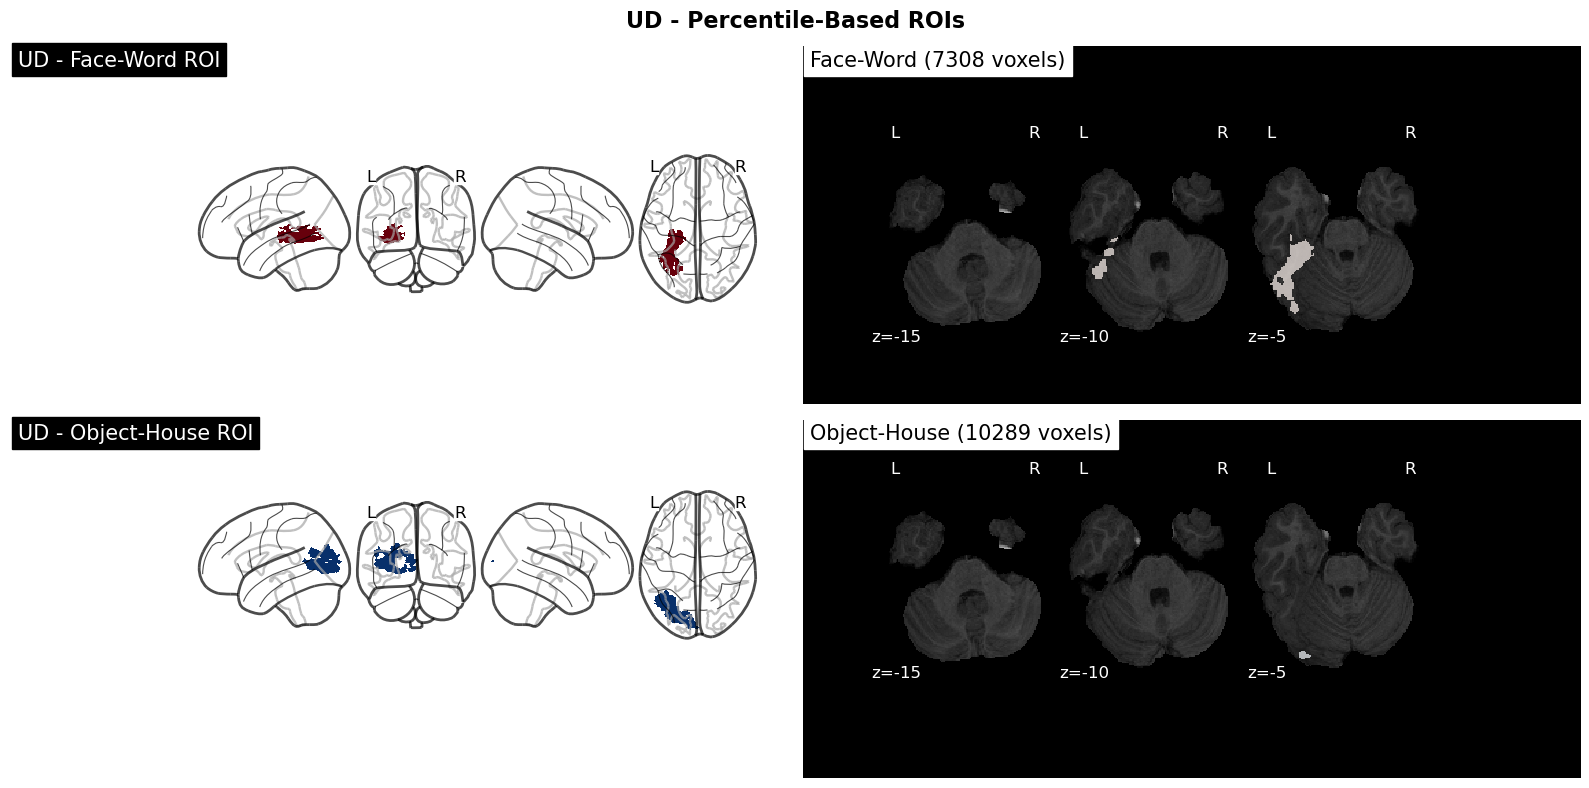

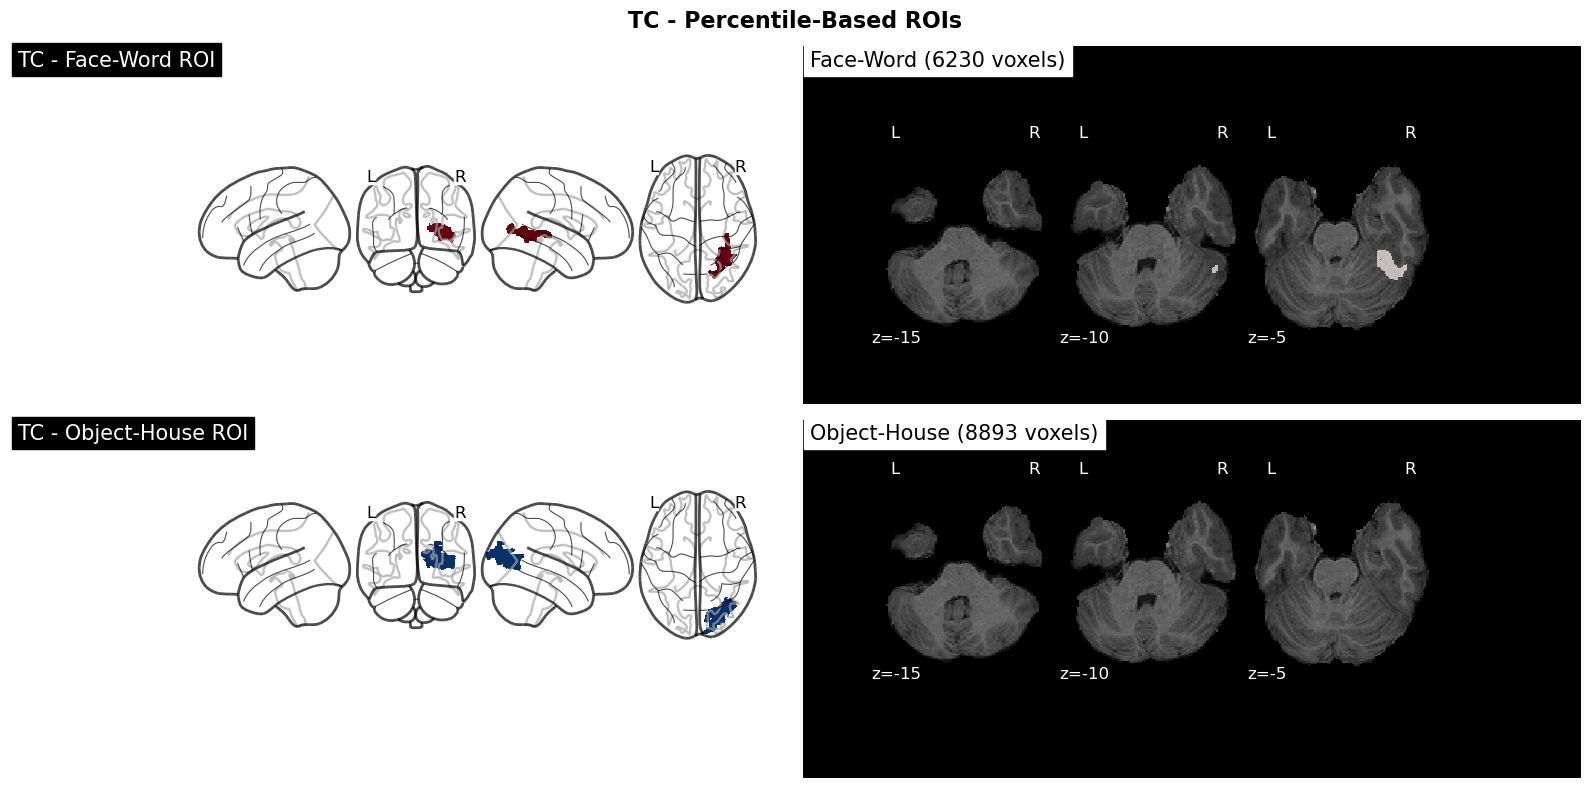

In [ ]:
# Glass brain visualization for percentile-based ROIs

for subject_id in ['sub-004', 'sub-021']:
    
    fig = plt.figure(figsize=(16, 8))
    
    # Face-word ROI
    fw_roi = roi_results_v2[subject_id]['face_word']['mask_file']
    
    # Glass brain - face-word
    ax1 = plt.subplot(2, 2, 1)
    plotting.plot_glass_brain(
        fw_roi, axes=ax1, title=f'{SUBJECTS[subject_id]["code"]} - Face-Word ROI',
        display_mode='lyrz', colorbar=False, plot_abs=False, cmap='Reds'
    )
    
    # Axial view - face-word
    ax2 = plt.subplot(2, 2, 2)
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    plotting.plot_roi(
        fw_roi, bg_img=anat_file, axes=ax2,
        title=f'Face-Word ({roi_results_v2[subject_id]["face_word"]["n_voxels"]} voxels)',
        display_mode='z', cut_coords=[-15, -10, -5],
        alpha=0.7, cmap='Reds'
    )
    
    # Object-house ROI
    oh_roi = roi_results_v2[subject_id]['object_house']['mask_file']
    
    # Glass brain - object-house
    ax3 = plt.subplot(2, 2, 3)
    plotting.plot_glass_brain(
        oh_roi, axes=ax3, title=f'{SUBJECTS[subject_id]["code"]} - Object-House ROI',
        display_mode='lyrz', colorbar=False, plot_abs=False, cmap='Blues'
    )
    
    # Axial view - object-house
    ax4 = plt.subplot(2, 2, 4)
    plotting.plot_roi(
        oh_roi, bg_img=anat_file, axes=ax4,
        title=f'Object-House ({roi_results_v2[subject_id]["object_house"]["n_voxels"]} voxels)',
        display_mode='z', cut_coords=[-15, -10, -5],
        alpha=0.7, cmap='Blues'
    )
    
    plt.suptitle(f'{SUBJECTS[subject_id]["code"]} - Percentile-Based ROIs', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_percentile_rois_glass.png', dpi=150)
    plt.show()

Creating surface plot for sub-004...


<Figure size 1200x500 with 0 Axes>

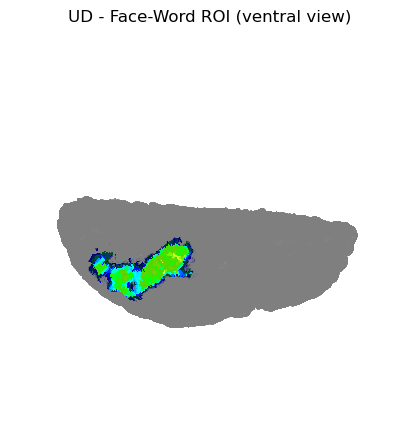

In [9]:
# FIXED: Surface plot with correct hemisphere parameter

from nilearn import surface

for subject_id in ['sub-004']:  # Start with one
    hemi_code = SUBJECTS[subject_id]['hemi']  # 'l' or 'r'
    hemi_str = 'lh' if hemi_code == 'l' else 'rh'
    hemi_full = 'left' if hemi_code == 'l' else 'right'  # For nilearn
    
    fs_subject = f'{subject_id}_ses-01'
    fs_dir = Path('/lab_data/behrmannlab/hemi/FS')
    
    # Check if surface exists
    pial_file = fs_dir / fs_subject / 'surf' / f'{hemi_str}.pial'
    
    if pial_file.exists():
        print(f"Creating surface plot for {subject_id}...")
        
        # Load surface
        surf_mesh = str(pial_file)
        
        # Project ROI to surface
        fw_roi = roi_results_v2[subject_id]['face_word']['mask_file']
        texture = surface.vol_to_surf(str(fw_roi), surf_mesh)
        
        # Plot
        fig = plt.figure(figsize=(12, 5))
        
        plotting.plot_surf_roi(surf_mesh, roi_map=texture,
                              hemi=hemi_full,  # FIXED: use 'left' not 'l'
                              view='ventral', bg_map=None,
                              title=f'{SUBJECTS[subject_id]["code"]} - Face-Word ROI (ventral view)')
        
        plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_surface_roi.png', dpi=150)
        plt.show()
    else:
        print(f"Surface file not found: {pial_file}")

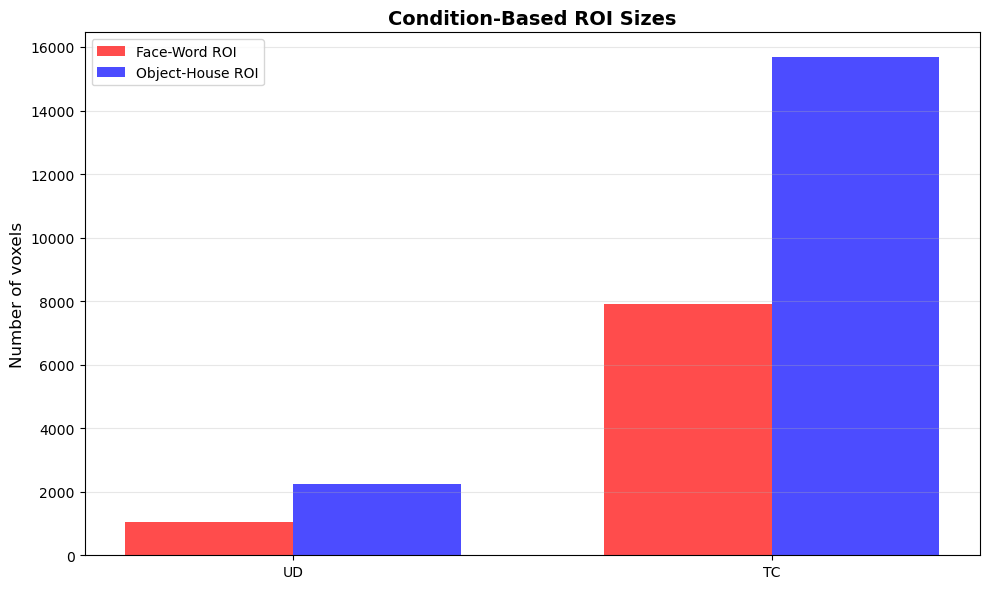


ROI Creation Complete!

UD:
  Face-Word: 1057 voxels
  Object-House: 2236 voxels

TC:
  Face-Word: 7900 voxels
  Object-House: 15677 voxels


In [5]:
# VISUALIZATION 4: ROI size comparison

fig, ax = plt.subplots(figsize=(10, 6))

subjects = ['sub-004', 'sub-021']
x = np.arange(len(subjects))
width = 0.35

fw_sizes = [roi_results[s]['face_word']['n_voxels'] for s in subjects]
oh_sizes = [roi_results[s]['object_house']['n_voxels'] for s in subjects]

ax.bar(x - width/2, fw_sizes, width, label='Face-Word ROI', color='red', alpha=0.7)
ax.bar(x + width/2, oh_sizes, width, label='Object-House ROI', color='blue', alpha=0.7)

ax.set_ylabel('Number of voxels', fontsize=12)
ax.set_title('Condition-Based ROI Sizes', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([SUBJECTS[s]['code'] for s in subjects])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'roi_size_comparison.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("ROI Creation Complete!")
print("="*60)
for subject_id in subjects:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    print(f"  Face-Word: {roi_results[subject_id]['face_word']['n_voxels']} voxels")
    print(f"  Object-House: {roi_results[subject_id]['object_house']['n_voxels']} voxels")

In [4]:
def create_dual_cluster_roi(subject_id, roi_type='face_word', 
                           target_percentile=75, min_voxels_per_category=3000):
    """
    Create ROI from TWO separate clusters (face AND word, or object AND house)
    Combine via union to ensure both categories represented
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()} (Dual-Cluster)")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and individual condition copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope1_name = 6, 'face'  # face>all
        cope2_num, cope2_name = 9, 'word'  # word>all
    else:  # object_house
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope1_name = 8, 'object'  # object>all
        cope2_num, cope2_name = 7, 'house'   # house>all
    
    # Load anatomical mask
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load individual conditions
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # === CLUSTER 1 (e.g., face) ===
    print(f"\nFinding {cope1_name} cluster...")
    roi1_values = cope1_data[anat_mask]
    threshold1 = np.percentile(roi1_values, target_percentile)
    
    mask1 = (cope1_data > threshold1) & anat_mask
    labeled1, n_clusters1 = ndimage.label(mask1)
    
    if n_clusters1 > 0:
        cluster_sizes1 = [(labeled1 == i).sum() for i in range(1, n_clusters1 + 1)]
        largest_idx1 = np.argmax(cluster_sizes1) + 1
        cluster1_mask = (labeled1 == largest_idx1)
        n_vox1 = cluster_sizes1[largest_idx1 - 1]
        print(f"  {cope1_name}: {n_vox1} voxels (threshold z>{threshold1:.2f})")
    else:
        cluster1_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox1 = 0
        print(f"  {cope1_name}: No clusters found")
    
    # === CLUSTER 2 (e.g., word) ===
    print(f"Finding {cope2_name} cluster...")
    roi2_values = cope2_data[anat_mask]
    threshold2 = np.percentile(roi2_values, target_percentile)
    
    mask2 = (cope2_data > threshold2) & anat_mask
    labeled2, n_clusters2 = ndimage.label(mask2)
    
    if n_clusters2 > 0:
        cluster_sizes2 = [(labeled2 == i).sum() for i in range(1, n_clusters2 + 1)]
        largest_idx2 = np.argmax(cluster_sizes2) + 1
        cluster2_mask = (labeled2 == largest_idx2)
        n_vox2 = cluster_sizes2[largest_idx2 - 1]
        print(f"  {cope2_name}: {n_vox2} voxels (threshold z>{threshold2:.2f})")
    else:
        cluster2_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox2 = 0
        print(f"  {cope2_name}: No clusters found")
    
    # === UNION (no double counting) ===
    combined_mask = cluster1_mask | cluster2_mask
    n_total = np.sum(combined_mask)
    n_overlap = np.sum(cluster1_mask & cluster2_mask)
    
    print(f"\nCombined ROI:")
    print(f"  Total: {n_total} voxels")
    print(f"  {cope1_name} only: {n_vox1 - n_overlap}")
    print(f"  {cope2_name} only: {n_vox2 - n_overlap}")
    print(f"  Overlap: {n_overlap}")
    
    # Get center
    if n_total > 0:
        coords = np.where(combined_mask)
        center_vox = [np.mean(c) for c in coords]
        center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
        print(f"  Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    combined_img = nib.Nifti1Image(combined_mask.astype(np.float32), anat_roi.affine)
    nib.save(combined_img, output_file)
    print(f"  Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_total': n_total,
        'n_cluster1': n_vox1,
        'n_cluster2': n_vox2,
        'n_overlap': n_overlap,
        'cluster1_mask': cluster1_mask,
        'cluster2_mask': cluster2_mask
    }

# Create dual-cluster ROIs
roi_results_dual = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_dual[subject_id] = {}
    roi_results_dual[subject_id]['face_word'] = create_dual_cluster_roi(subject_id, 'face_word')
    roi_results_dual[subject_id]['object_house'] = create_dual_cluster_roi(subject_id, 'object_house')

# Summary
print("\n" + "="*60)
print("DUAL-CLUSTER ROI SUMMARY")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    fw = roi_results_dual[subject_id]['face_word']
    oh = roi_results_dual[subject_id]['object_house']
    print(f"  Face-Word: {fw['n_total']} voxels (face={fw['n_cluster1']}, word={fw['n_cluster2']}, overlap={fw['n_overlap']})")
    print(f"  Object-House: {oh['n_total']} voxels (object={oh['n_cluster1']}, house={oh['n_cluster2']}, overlap={oh['n_overlap']})")


sub-004 - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 5024 voxels (threshold z>0.35)
Finding word cluster...
  word: 3891 voxels (threshold z>0.00)

Combined ROI:
  Total: 8023 voxels
  face only: 4132
  word only: 2999
  Overlap: 892
  Center: (-31.3, -44.1, -2.0)
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_dual_cluster.nii.gz

sub-004 - OBJECT_HOUSE (Dual-Cluster)

Finding object cluster...
  object: 6944 voxels (threshold z>1.86)
Finding house cluster...
  house: 7634 voxels (threshold z>0.39)

Combined ROI:
  Total: 13734 voxels
  object only: 6100
  house only: 6790
  Overlap: 844
  Center: (-24.7, -77.2, 13.3)
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_dual_cluster.nii.gz

sub-021 - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 4476 voxels (threshold z>5.53)
Finding word cluster...
  word: 2123 voxels (threshold z>-1.04)

Combined ROI:
  Total: 6366 voxels
  face only: 4243
  word only: 1890
  Overla

/tmp/ipykernel_3316781/485166046.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


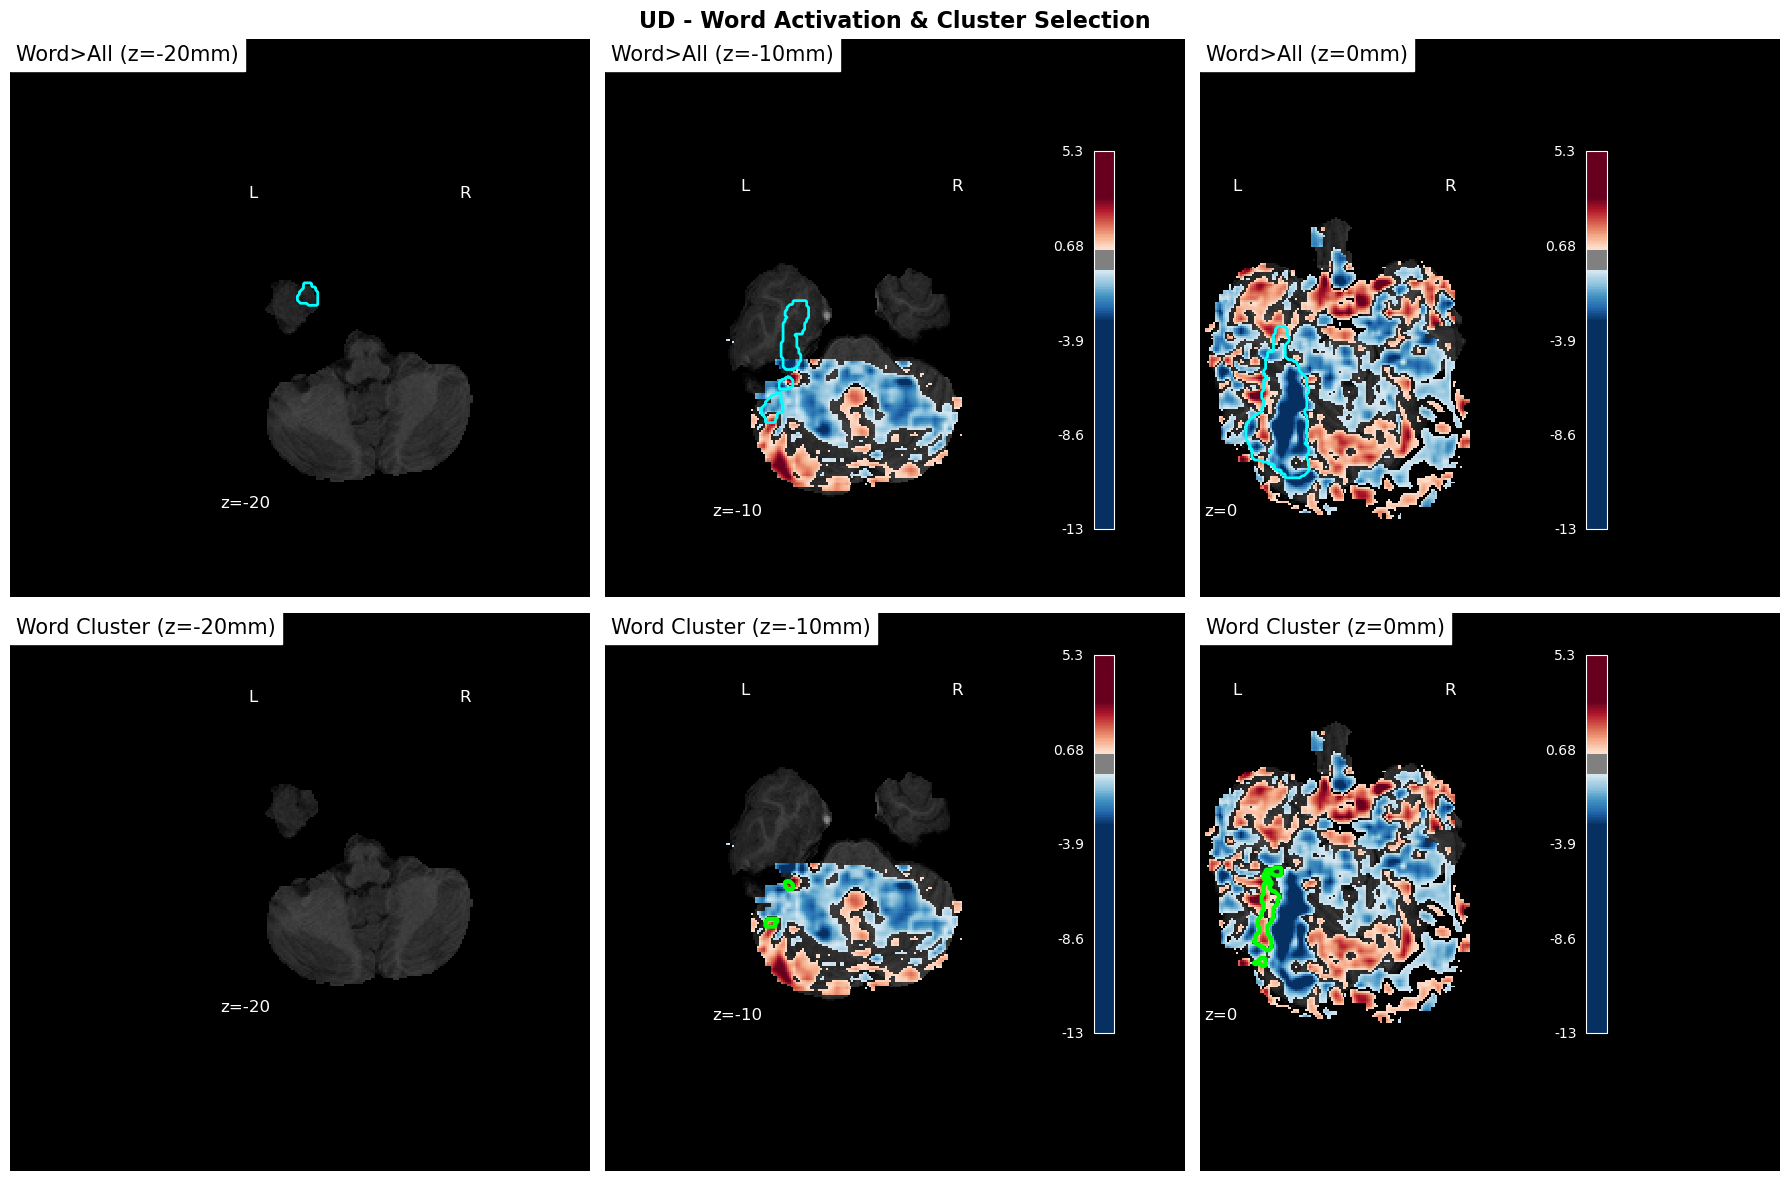

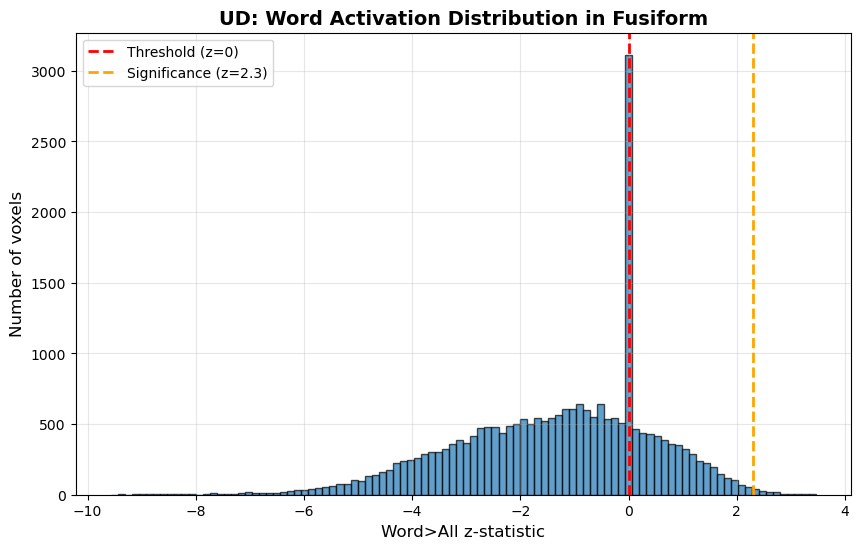

Word activation stats:
  Mean: -1.31
  Median: -1.03
  Min: -9.57, Max: 3.46
  Voxels > 0: 5033 (20.7%)
  Voxels > 2.3: 125 (0.5%)


In [6]:
# Visualize UD word activation (FIXED - remove vmin)

subject_id = 'sub-004'
hemi = 'l'

# Load files
anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
anat_boundary = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
word_activation = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                  'HighLevel.gfeat' / 'cope9.feat' / 'stats' / 'zstat1.nii.gz'
word_cluster = roi_results_dual[subject_id]['face_word']['cluster2_mask']

# Create word cluster image
word_cluster_img = nib.Nifti1Image(word_cluster.astype(np.float32), 
                                    nib.load(anat_boundary).affine)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Word activation with anatomical boundary
for idx, z_coord in enumerate([-20, -10, 0]):
    ax = axes[0, idx]
    
    display = plotting.plot_stat_map(
        word_activation, bg_img=anat_file, axes=ax,
        threshold=0.5, title=f'Word>All (z={z_coord}mm)',
        display_mode='z', cut_coords=[z_coord],
        cmap='RdBu_r', symmetric_cbar=False, vmax=3, colorbar=True
    )
    display.add_contours(anat_boundary, levels=[0.5], colors='cyan', linewidths=2)

# Row 2: Word cluster selection
for idx, z_coord in enumerate([-20, -10, 0]):
    ax = axes[1, idx]
    
    display = plotting.plot_stat_map(
        word_activation, bg_img=anat_file, axes=ax,
        threshold=0.5, title=f'Word Cluster (z={z_coord}mm)',
        display_mode='z', cut_coords=[z_coord],
        cmap='RdBu_r', symmetric_cbar=False, vmax=3, colorbar=True
    )
    display.add_contours(word_cluster_img, levels=[0.5], colors='lime', linewidths=3)

fig.suptitle('UD - Word Activation & Cluster Selection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'sub-004_word_cluster_review.png', dpi=150)
plt.show()

# Histogram
anat_mask = nib.load(anat_boundary).get_fdata() > 0
word_data = nib.load(word_activation).get_fdata()
word_values = word_data[anat_mask]

plt.figure(figsize=(10, 6))
plt.hist(word_values, bins=100, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Threshold (z=0)')
plt.axvline(2.3, color='orange', linestyle='--', linewidth=2, label='Significance (z=2.3)')
plt.xlabel('Word>All z-statistic', fontsize=12)
plt.ylabel('Number of voxels', fontsize=12)
plt.title('UD: Word Activation Distribution in Fusiform', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Word activation stats:")
print(f"  Mean: {word_values.mean():.2f}")
print(f"  Median: {np.median(word_values):.2f}")
print(f"  Min: {word_values.min():.2f}, Max: {word_values.max():.2f}")
print(f"  Voxels > 0: {np.sum(word_values > 0)} ({100*np.sum(word_values > 0)/len(word_values):.1f}%)")
print(f"  Voxels > 2.3: {np.sum(word_values > 2.3)} ({100*np.sum(word_values > 2.3)/len(word_values):.1f}%)")

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_face_word_figure5_dual.png


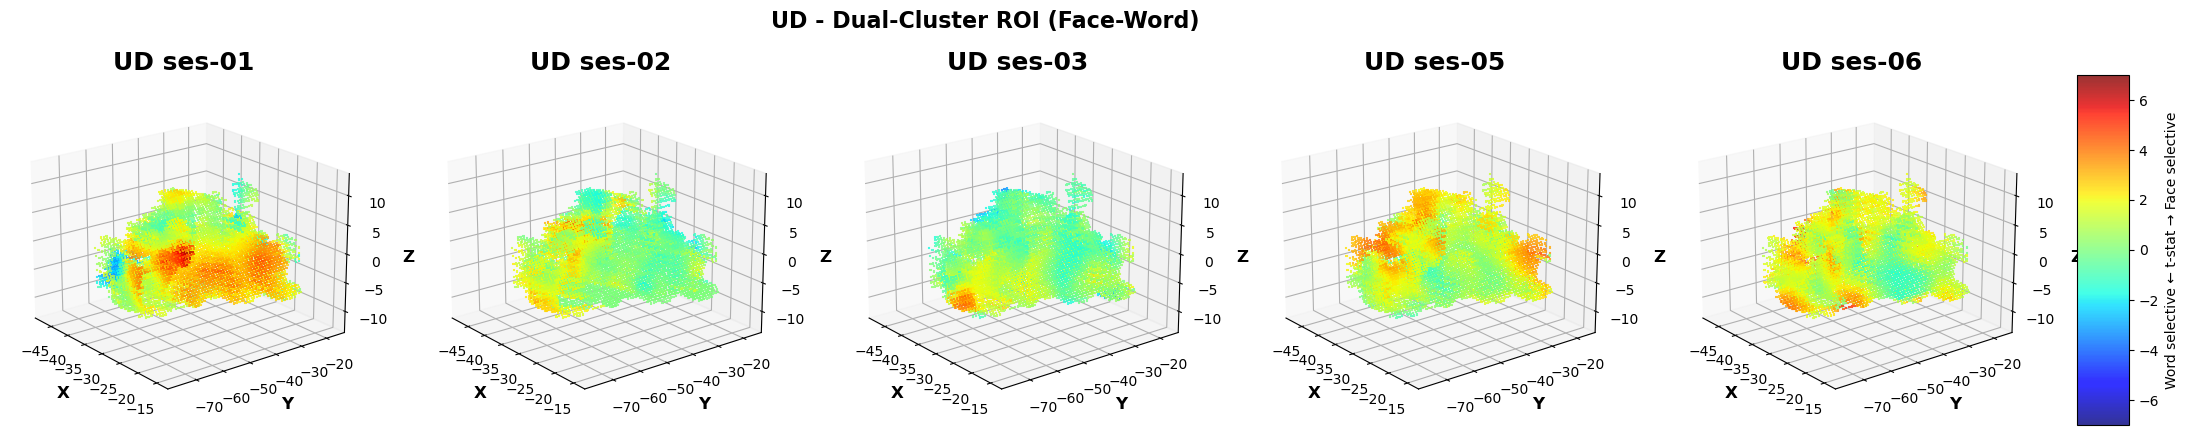

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_object_house_figure5_dual.png


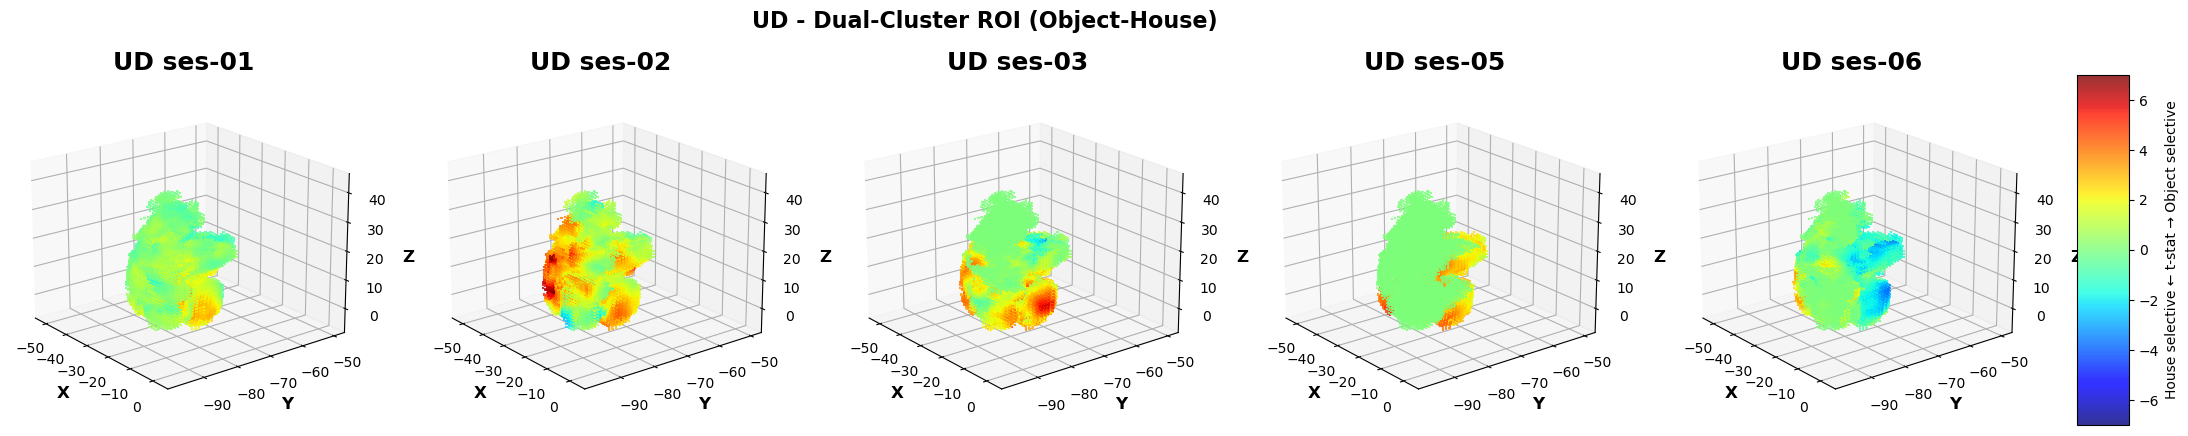

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_face_word_figure5_dual.png


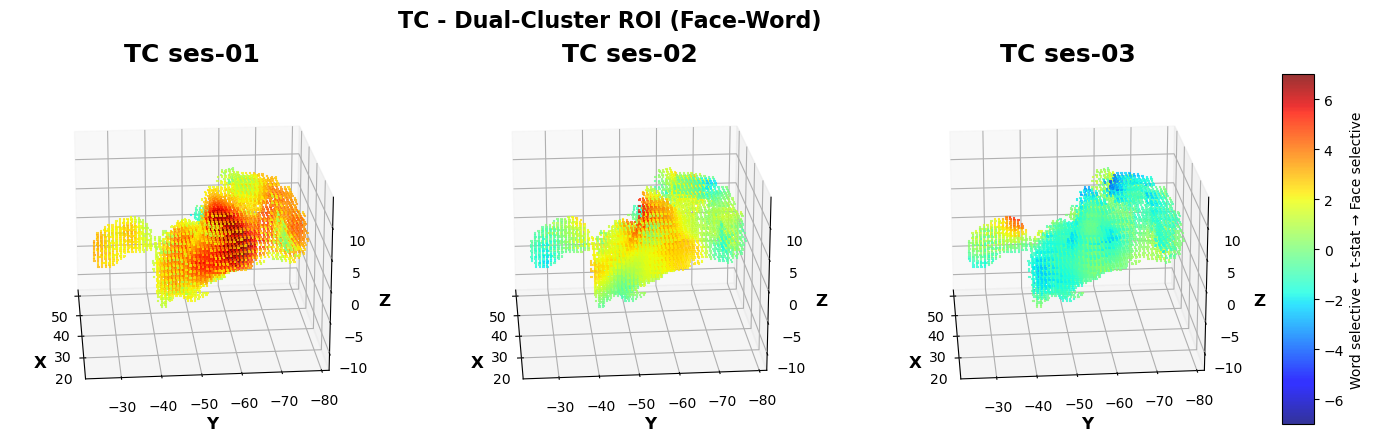

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_object_house_figure5_dual.png


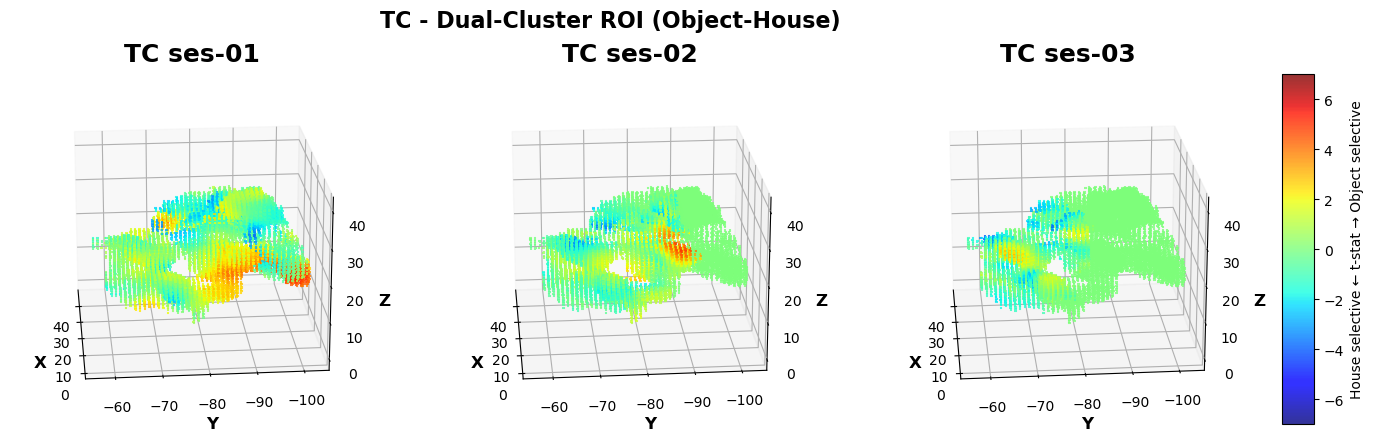

In [23]:
# Figure 5 style visualization for dual-cluster ROIs

def create_figure5_dual_cluster(subject_id, roi_type='face_word', save_path=None):
    """Figure 5 style 3D visualization for dual-cluster ROI"""
    
    info = SUBJECTS[subject_id]
    session_data = dual_extractions[subject_id][roi_type]['data']
    sessions = [s for s in info['sessions'] if s in session_data]
    n_sessions = len(sessions)
    
    fig = plt.figure(figsize=(5*n_sessions + 1, 5))
    
    for i, ses in enumerate(sessions):
        data = session_data[ses]
        coords = data[:, :3]
        t_stats = data[:, 3]
        
        ax = fig.add_subplot(1, n_sessions, i+1, projection='3d')
        
        # View angle
        view = (20, 175) if info['hemi'] == 'r' else (20, 322)
        
        scatter = ax.scatter(coords[:,0], coords[:,1], coords[:,2],
                           c=t_stats, s=3, marker='+',
                           cmap='jet', vmin=-7, vmax=7, alpha=0.8)
        
        ax.set_xlabel('X', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z', fontsize=12, fontweight='bold')
        ax.set_title(f'{info["code"]} ses-{ses}', fontsize=18, fontweight='bold')
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    
    if roi_type == 'face_word':
        cbar.set_label('Word selective ← t-stat → Face selective', fontsize=10)
    else:
        cbar.set_label('House selective ← t-stat → Object selective', fontsize=10)
    
    roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    fig.suptitle(f'{info["code"]} - Dual-Cluster ROI ({roi_label})', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Create visualizations for both contrasts
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        save_path = BASE_DIR / 'analyses' / f'{subject_id}_{roi_type}_figure5_dual.png'
        create_figure5_dual_cluster(subject_id, roi_type, save_path)

In [7]:
# Extract cope 13 from dual-cluster ROIs

def extract_dual_cluster_longitudinal(subject_id, roi_type='face_word'):
    """Extract contrast from dual-cluster ROI across sessions"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    # Determine contrast cope
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    session_means = {}
    
    for session in SUBJECTS[subject_id]['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            zstat_data = zstat_img.get_fdata()
            t_stats = zstat_data[voxel_indices]
            
            # Store for Figure 5
            session_data[session] = np.column_stack([world_coords, t_stats])
            session_means[session] = t_stats.mean()
            
            print(f"{subject_id} {roi_type} ses-{session}: mean={t_stats.mean():.2f}, std={t_stats.std():.2f}")
    
    return session_data, session_means

# Extract for all subjects
print("Extracting dual-cluster ROI data...")
print("="*60)

dual_extractions = {}
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    dual_extractions[subject_id] = {}
    
    for roi_type in ['face_word', 'object_house']:
        print(f"\n  {roi_type}:")
        data, means = extract_dual_cluster_longitudinal(subject_id, roi_type)
        dual_extractions[subject_id][roi_type] = {'data': data, 'means': means}

Extracting dual-cluster ROI data...

UD:

  face_word:
sub-004 face_word ses-01: mean=1.62, std=1.49
sub-004 face_word ses-02: mean=0.47, std=1.10
sub-004 face_word ses-03: mean=0.29, std=1.05
sub-004 face_word ses-05: mean=1.27, std=1.16
sub-004 face_word ses-06: mean=1.45, std=1.09

  object_house:
sub-004 object_house ses-01: mean=0.73, std=1.10
sub-004 object_house ses-02: mean=1.89, std=1.46
sub-004 object_house ses-03: mean=1.37, std=1.48
sub-004 object_house ses-05: mean=1.20, std=1.52
sub-004 object_house ses-06: mean=-0.49, std=1.20

TC:

  face_word:
sub-021 face_word ses-01: mean=2.95, std=2.03
sub-021 face_word ses-02: mean=1.29, std=1.29
sub-021 face_word ses-03: mean=-0.61, std=0.98

  object_house:
sub-021 object_house ses-01: mean=0.39, std=1.58
sub-021 object_house ses-02: mean=-0.01, std=0.93
sub-021 object_house ses-03: mean=-0.13, std=0.70


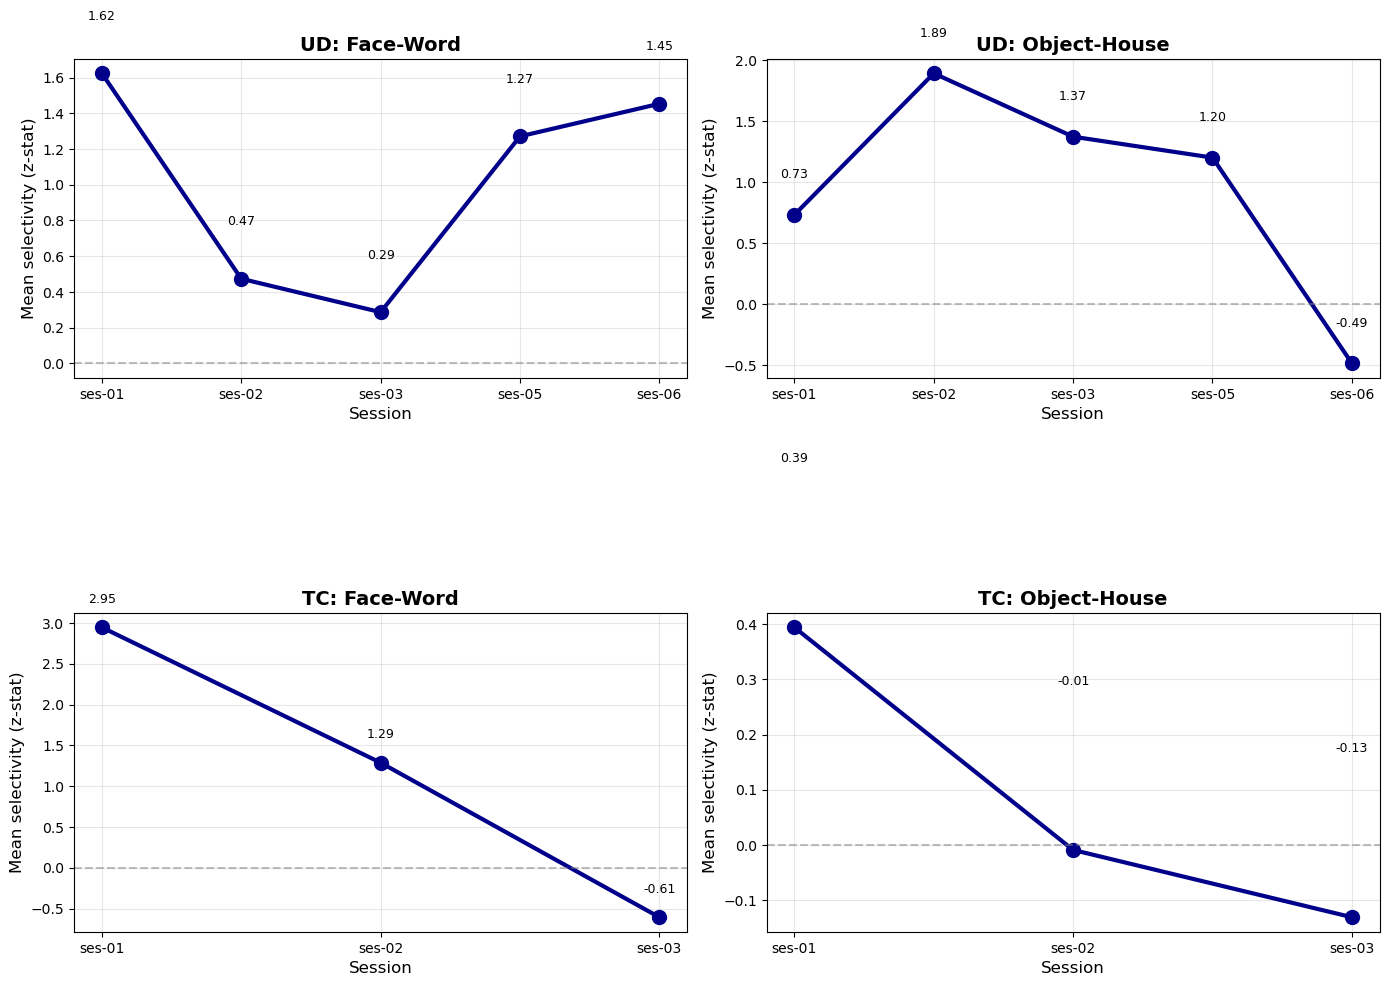


Extraction and visualization complete!


In [21]:
# Plot longitudinal progression

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for subj_idx, subject_id in enumerate(['sub-004', 'sub-021']):
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    for roi_idx, roi_type in enumerate(['face_word', 'object_house']):
        ax = axes[subj_idx, roi_idx]
        
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        # Get values in order
        sessions_available = [s for s in sessions if s in means_dict]
        means = [means_dict[s] for s in sessions_available]
        
        # Plot
        ax.plot(range(len(means)), means, 'o-', linewidth=3, markersize=10, color='darkblue')
        ax.set_xticks(range(len(sessions_available)))
        ax.set_xticklabels([f'ses-{s}' for s in sessions_available])
        ax.set_ylabel('Mean selectivity (z-stat)', fontsize=12)
        ax.set_xlabel('Session', fontsize=12)
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        # Title
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        ax.set_title(f'{code}: {roi_label}', fontsize=14, fontweight='bold')
        
        # Annotate values
        for i, (ses, val) in enumerate(zip(sessions_available, means)):
            ax.text(i, val + 0.3, f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'dual_cluster_longitudinal.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("Extraction and visualization complete!")

In [8]:
# Comprehensive results summary

print("="*80)
print("DUAL-CLUSTER ROI ANALYSIS - RESULTS SUMMARY")
print("="*80)

print("\n" + "="*80)
print("1. ROI COMPOSITION (ses-01)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} ({subject_id}):")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        result = roi_results_dual[subject_id][roi_type]
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        
        print(f"\n  {roi_label} ROI:")
        print(f"    Total voxels: {result['n_total']}")
        
        if roi_type == 'face_word':
            print(f"    Face-only: {result['n_cluster1'] - result['n_overlap']} ({100*(result['n_cluster1'] - result['n_overlap'])/result['n_total']:.1f}%)")
            print(f"    Word-only: {result['n_cluster2'] - result['n_overlap']} ({100*(result['n_cluster2'] - result['n_overlap'])/result['n_total']:.1f}%)")
        else:
            print(f"    Object-only: {result['n_cluster1'] - result['n_overlap']} ({100*(result['n_cluster1'] - result['n_overlap'])/result['n_total']:.1f}%)")
            print(f"    House-only: {result['n_cluster2'] - result['n_overlap']} ({100*(result['n_cluster2'] - result['n_overlap'])/result['n_total']:.1f}%)")
        print(f"    Overlap: {result['n_overlap']} ({100*result['n_overlap']/result['n_total']:.1f}%)")

print("\n" + "="*80)
print("2. LONGITUDINAL SELECTIVITY (Mean z-statistics per session)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        print(f"\n  {roi_label}:")
        for ses in SUBJECTS[subject_id]['sessions']:
            if ses in means_dict:
                print(f"    ses-{ses}: {means_dict[ses]:+.2f}")

print("\n" + "="*80)
print("3. SESSION-TO-SESSION CHANGES")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        means_dict = dual_extractions[subject_id][roi_type]['means']
        sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in means_dict]
        
        print(f"\n  {roi_label}:")
        for i in range(len(sessions)-1):
            ses1, ses2 = sessions[i], sessions[i+1]
            change = means_dict[ses2] - means_dict[ses1]
            print(f"    ses-{ses1} → ses-{ses2}: {change:+.2f}")
        
        # Overall change
        if len(sessions) >= 2:
            total_change = means_dict[sessions[-1]] - means_dict[sessions[0]]
            print(f"    Overall (ses-{sessions[0]} → ses-{sessions[-1]}): {total_change:+.2f}")

print("\n" + "="*80)
print("4. COMPARISON TO LIU ET AL. EXPECTATIONS")
print("="*80)

print("\nLiu et al. findings:")
print("  UD: Progressive INCREASE in face-word selectivity")
print("  TC: Significant changes over time")
print("  OT: No significant change (control)")

print("\nYour findings:")
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    means_dict = dual_extractions[subject_id]['face_word']['means']
    sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in means_dict]
    
    if len(sessions) >= 2:
        baseline = means_dict[sessions[0]]
        final = means_dict[sessions[-1]]
        change = final - baseline
        
        pattern = "INCREASE" if change > 0 else "DECREASE"
        print(f"  {code}: {pattern} ({baseline:.2f} → {final:.2f}, Δ={change:+.2f})")

print("\n" + "="*80)
print("5. KEY OBSERVATIONS")
print("="*80)

# Analyze patterns
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    fw_means = dual_extractions[subject_id]['face_word']['means']
    oh_means = dual_extractions[subject_id]['object_house']['means']
    
    fw_sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in fw_means]
    oh_sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in oh_means]
    
    print(f"\n{code}:")
    
    # Face-word trajectory
    if len(fw_sessions) >= 2:
        fw_values = [fw_means[s] for s in fw_sessions]
        fw_trend = "increasing" if fw_values[-1] > fw_values[0] else "decreasing"
        fw_stable = all(abs(fw_values[i+1] - fw_values[i]) < 0.5 for i in range(len(fw_values)-1))
        
        print(f"  Face-Word: {fw_trend} trajectory")
        if fw_stable:
            print(f"    Relatively stable (max change < 0.5)")
    
    # Object-house trajectory  
    if len(oh_sessions) >= 2:
        oh_values = [oh_means[s] for s in oh_sessions]
        oh_trend = "increasing" if oh_values[-1] > oh_values[0] else "decreasing"
        oh_stable = all(abs(oh_values[i+1] - oh_values[i]) < 0.5 for i in range(len(oh_values)-1))
        
        print(f"  Object-House: {oh_trend} trajectory")
        if oh_stable:
            print(f"    Relatively stable (max change < 0.5)")

print("\n" + "="*80)
print("END OF SUMMARY")
print("="*80)

DUAL-CLUSTER ROI ANALYSIS - RESULTS SUMMARY

1. ROI COMPOSITION (ses-01)

UD (sub-004):
----------------------------------------

  Face-Word ROI:
    Total voxels: 8023
    Face-only: 4132 (51.5%)
    Word-only: 2999 (37.4%)
    Overlap: 892 (11.1%)

  Object-House ROI:
    Total voxels: 13734
    Object-only: 6100 (44.4%)
    House-only: 6790 (49.4%)
    Overlap: 844 (6.1%)

TC (sub-021):
----------------------------------------

  Face-Word ROI:
    Total voxels: 6366
    Face-only: 4243 (66.7%)
    Word-only: 1890 (29.7%)
    Overlap: 233 (3.7%)

  Object-House ROI:
    Total voxels: 10405
    Object-only: 6223 (59.8%)
    House-only: 4088 (39.3%)
    Overlap: 94 (0.9%)

2. LONGITUDINAL SELECTIVITY (Mean z-statistics per session)

UD:
----------------------------------------

  Face-Word:
    ses-01: +1.62
    ses-02: +0.47
    ses-03: +0.29
    ses-05: +1.27
    ses-06: +1.45

  Object-House:
    ses-01: +0.73
    ses-02: +1.89
    ses-03: +1.37
    ses-05: +1.20
    ses-06: -0.49

In [9]:
# Check for significant activation in each category

for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{'='*60}")
    print(f"{SUBJECTS[subject_id]['code']} - Significant Activation Check")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
    anat_mask = nib.load(anat_file).get_fdata() > 0
    
    # Check face and word
    for cope_num, cope_name in [(6, 'face'), (9, 'word')]:
        cope_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                    'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
        
        cope_data = nib.load(cope_file).get_fdata()
        roi_values = cope_data[anat_mask]
        
        print(f"\n{cope_name.upper()} (cope {cope_num}):")
        print(f"  Mean: {roi_values.mean():.2f}")
        print(f"  Max: {roi_values.max():.2f}")
        print(f"  Voxels z>2.3: {np.sum(roi_values > 2.3)} ({100*np.sum(roi_values > 2.3)/len(roi_values):.1f}%)")
        print(f"  Voxels z>1.96: {np.sum(roi_values > 1.96)} ({100*np.sum(roi_values > 1.96)/len(roi_values):.1f}%)")
        
        # Check if clusters exist
        sig_mask = (cope_data > 2.3) & anat_mask
        labeled, n_clusters = ndimage.label(sig_mask)
        if n_clusters > 0:
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            print(f"  Significant clusters (z>2.3): {n_clusters}, largest = {max(cluster_sizes)} voxels")
        else:
            print(f"  Significant clusters (z>2.3): NONE")


UD - Significant Activation Check

FACE (cope 6):
  Mean: -0.48
  Max: 4.56
  Voxels z>2.3: 1458 (6.0%)
  Voxels z>1.96: 2029 (8.3%)
  Significant clusters (z>2.3): 6, largest = 1046 voxels

WORD (cope 9):
  Mean: -1.31
  Max: 3.46
  Voxels z>2.3: 125 (0.5%)
  Voxels z>1.96: 311 (1.3%)
  Significant clusters (z>2.3): 13, largest = 57 voxels

TC - Significant Activation Check

FACE (cope 6):
  Mean: 3.27
  Max: 20.44
  Voxels z>2.3: 8393 (46.8%)
  Voxels z>1.96: 9080 (50.6%)
  Significant clusters (z>2.3): 10, largest = 7862 voxels

WORD (cope 9):
  Mean: -2.60
  Max: 3.98
  Voxels z>2.3: 55 (0.3%)
  Voxels z>1.96: 83 (0.5%)
  Significant clusters (z>2.3): 4, largest = 52 voxels


In [10]:
# Extract from pure anatomical ROI (no functional localization)

def extract_anatomical_roi_longitudinal(subject_id, roi_type='face_word'):
    """Extract contrast from anatomical ROI - captures reorganization"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Use dilated anatomical mask
    if roi_type == 'face_word':
        roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        contrast_cope = 13
    else:
        roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        contrast_cope = 14
    
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    session_means = {}
    
    for session in SUBJECTS[subject_id]['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            t_stats = zstat_data[voxel_indices]
            session_means[session] = t_stats.mean()
            print(f"{subject_id} {roi_type} ses-{session}: mean={t_stats.mean():.2f}")
    
    return session_means

# Extract anatomical
print("ANATOMICAL ROI EXTRACTION")
print("="*60)

anat_results = {}
for subject_id in ['sub-004', 'sub-021']:
    anat_results[subject_id] = {}
    for roi_type in ['face_word', 'object_house']:
        anat_results[subject_id][roi_type] = extract_anatomical_roi_longitudinal(subject_id, roi_type)
        

ANATOMICAL ROI EXTRACTION
sub-004 face_word ses-01: mean=1.37
sub-004 face_word ses-02: mean=0.43
sub-004 face_word ses-03: mean=-0.05
sub-004 face_word ses-05: mean=1.34
sub-004 face_word ses-06: mean=1.41
sub-004 object_house ses-01: mean=0.54
sub-004 object_house ses-02: mean=1.50
sub-004 object_house ses-03: mean=1.23
sub-004 object_house ses-05: mean=1.10
sub-004 object_house ses-06: mean=-0.43
sub-021 face_word ses-01: mean=1.00
sub-021 face_word ses-02: mean=0.71
sub-021 face_word ses-03: mean=-0.89
sub-021 object_house ses-01: mean=0.18
sub-021 object_house ses-02: mean=-0.09
sub-021 object_house ses-03: mean=-0.12


new start with final stats

In [20]:
# 1. Statistical comparison between sessions (matching Liu's analysis)

from scipy import stats

print("="*80)
print("STATISTICAL ANALYSIS: Pairwise Session Comparisons")
print("="*80)

def compare_sessions_stats(subject_id, roi_type='face_word'):
    """T-tests between all session pairs"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    # Load all sessions
    session_data = {}
    for session in SUBJECTS[subject_id]['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat = nib.load(zstat_file).get_fdata()
            session_data[session] = zstat[voxel_indices]
    
    sessions = sorted(session_data.keys())
    
    print(f"\n{SUBJECTS[subject_id]['code']} - {roi_type.upper()}")
    print("-"*60)
    
    # Pairwise comparisons
    results = []
    for i in range(len(sessions)):
        for j in range(i+1, len(sessions)):
            ses1, ses2 = sessions[i], sessions[j]
            
            t_stat, p_val = stats.ttest_rel(session_data[ses1], session_data[ses2])
            
            mean1 = session_data[ses1].mean()
            mean2 = session_data[ses2].mean()
            diff = mean2 - mean1
            
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            
            # Highlight ses-1 vs ses-2
            comparison = f"ses-{ses1} vs ses-{ses2}"
            if ses1 == sessions[0] and ses2 == sessions[1]:
                comparison += " [Liu: expect ns]"
            
            print(f"  {comparison}:")
            print(f"    Mean: {mean1:.2f} → {mean2:.2f} (Δ={diff:+.2f})")
            print(f"    t={t_stat:.3f}, p={p_val:.4f} {sig}")
            
            results.append({
                'ses1': ses1, 'ses2': ses2,
                'mean1': mean1, 'mean2': mean2,
                't': t_stat, 'p': p_val, 'sig': sig
            })
    
    return results

# Run for both subjects
stats_results = {}
for subject_id in ['sub-004', 'sub-021']:
    stats_results[subject_id] = {}
    for roi_type in ['face_word', 'object_house']:
        stats_results[subject_id][roi_type] = compare_sessions_stats(subject_id, roi_type)

STATISTICAL ANALYSIS: Pairwise Session Comparisons

UD - FACE_WORD
------------------------------------------------------------
  ses-01 vs ses-02 [Liu: expect ns]:
    Mean: 1.62 → 0.47 (Δ=-1.15)
    t=53.437, p=0.0000 ***
  ses-01 vs ses-03:
    Mean: 1.62 → 0.29 (Δ=-1.34)
    t=68.248, p=0.0000 ***
  ses-01 vs ses-05:
    Mean: 1.62 → 1.27 (Δ=-0.35)
    t=16.548, p=0.0000 ***
  ses-01 vs ses-06:
    Mean: 1.62 → 1.45 (Δ=-0.17)
    t=7.160, p=0.0000 ***
  ses-02 vs ses-03:
    Mean: 0.47 → 0.29 (Δ=-0.19)
    t=12.096, p=0.0000 ***
  ses-02 vs ses-05:
    Mean: 0.47 → 1.27 (Δ=+0.80)
    t=-48.195, p=0.0000 ***
  ses-02 vs ses-06:
    Mean: 0.47 → 1.45 (Δ=+0.98)
    t=-63.348, p=0.0000 ***
  ses-03 vs ses-05:
    Mean: 0.29 → 1.27 (Δ=+0.99)
    t=-52.382, p=0.0000 ***
  ses-03 vs ses-06:
    Mean: 0.29 → 1.45 (Δ=+1.17)
    t=-71.333, p=0.0000 ***
  ses-05 vs ses-06:
    Mean: 1.27 → 1.45 (Δ=+0.18)
    t=-10.085, p=0.0000 ***

UD - OBJECT_HOUSE
------------------------------------------


Creating Figure 5 visualizations...
Saved: /user_data/csimmon2/long_pt/analyses/sub-004_face_word_figure5_liu_style.png


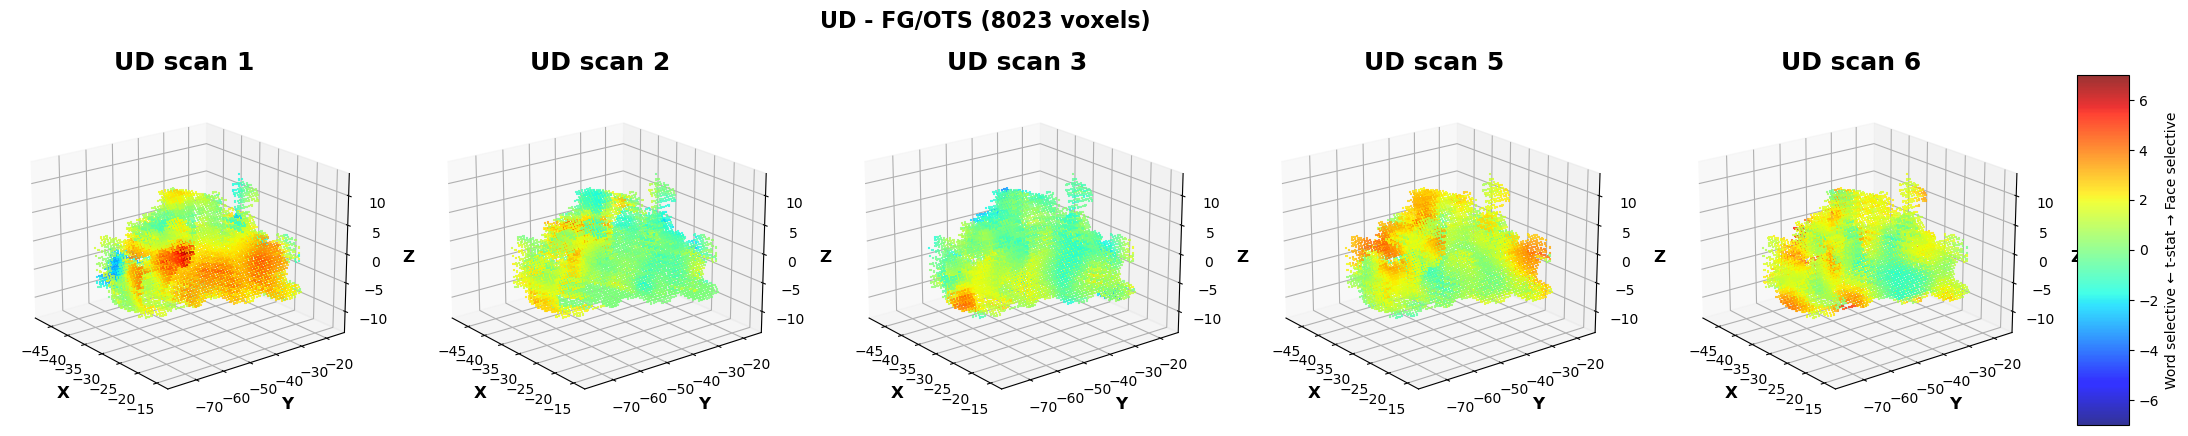

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_object_house_figure5_liu_style.png


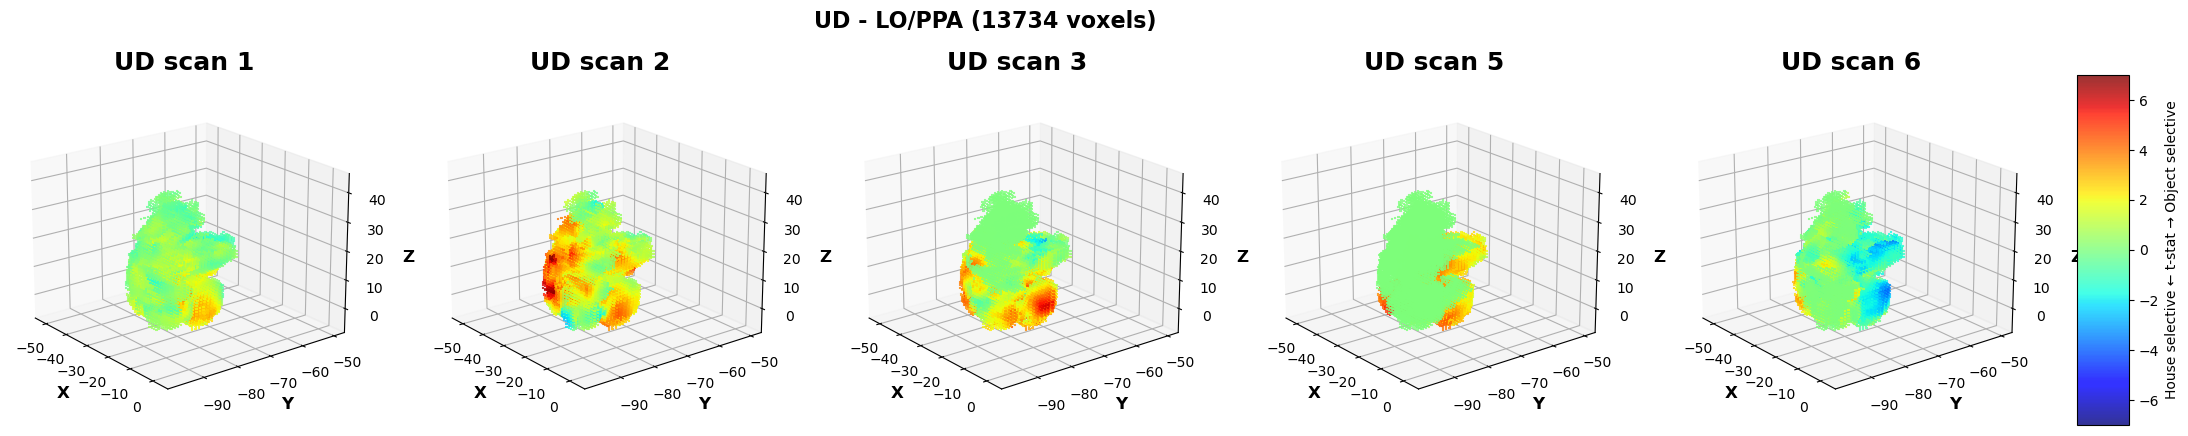

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_face_word_figure5_liu_style.png


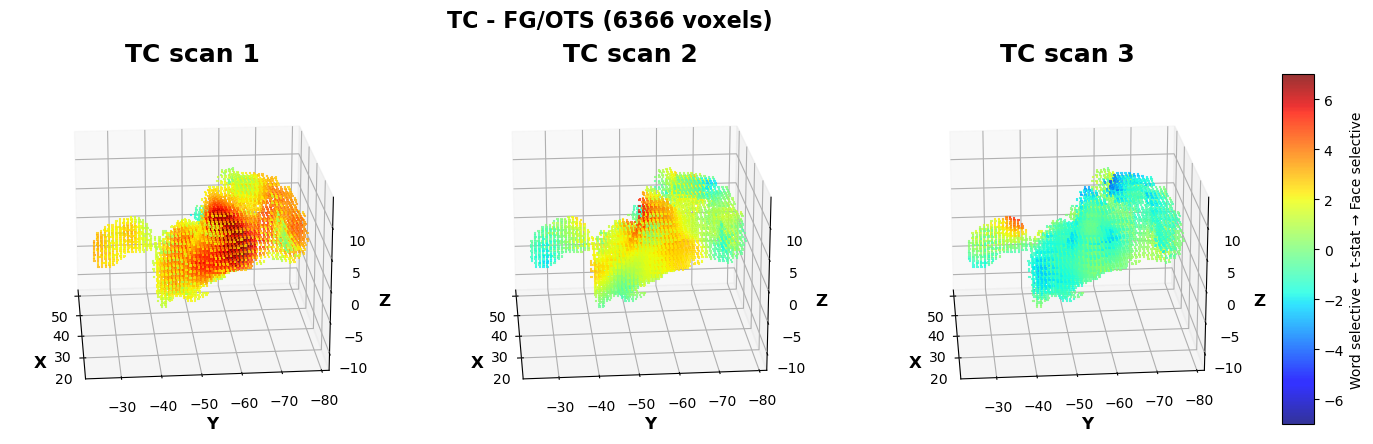

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_object_house_figure5_liu_style.png


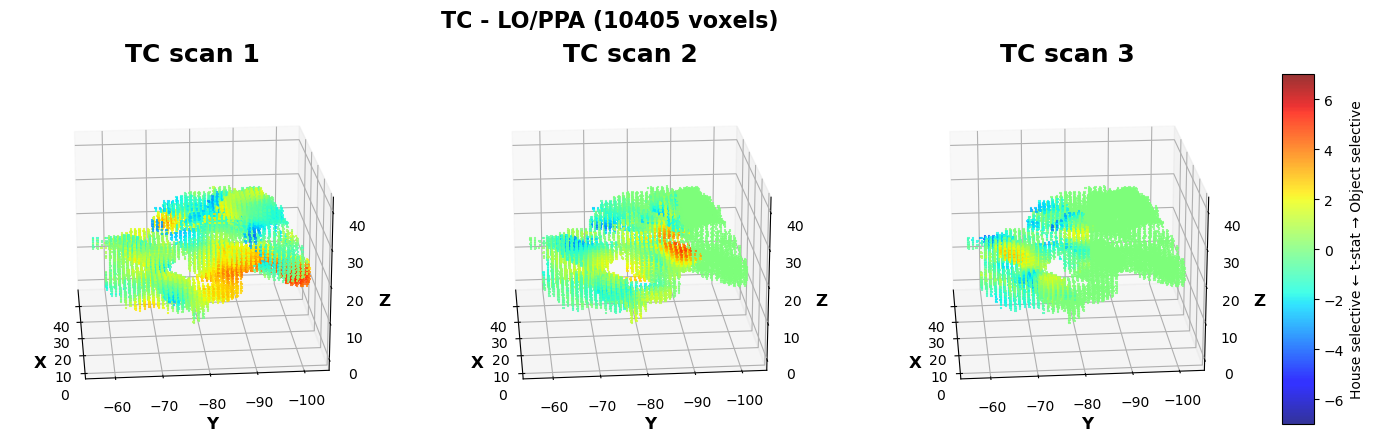

In [21]:
# 2. Figure 5 style visualization with dual-cluster ROIs

def create_figure5_liu_style(subject_id, roi_type='face_word', save_path=None):
    """
    Recreate Liu's Figure 5 visualization
    3D scatter plots showing selectivity changes over time
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    info = SUBJECTS[subject_id]
    
    # Load dual-cluster ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    # Extract contrast for all sessions
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    for session in info['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            t_stats = zstat_data[voxel_indices]
            session_data[session] = t_stats
    
    sessions = sorted(session_data.keys())
    n_sessions = len(sessions)
    
    # Create figure
    fig = plt.figure(figsize=(5*n_sessions + 1, 5))
    
    for i, ses in enumerate(sessions):
        t_stats = session_data[ses]
        
        ax = fig.add_subplot(1, n_sessions, i+1, projection='3d')
        
        # View angle (match Liu)
        view = (20, 175) if info['hemi'] == 'r' else (20, 322)
        
        scatter = ax.scatter(world_coords[:,0], world_coords[:,1], world_coords[:,2],
                           c=t_stats, s=3, marker='+',
                           cmap='jet', vmin=-7, vmax=7, alpha=0.8)
        
        ax.set_xlabel('X', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z', fontsize=12, fontweight='bold')
        ax.set_title(f'{info["code"]} scan {int(ses)}', fontsize=18, fontweight='bold')
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    # Colorbar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    
    if roi_type == 'face_word':
        cbar.set_label('Word selective ← t-stat → Face selective', fontsize=10)
    else:
        cbar.set_label('House selective ← t-stat → Object selective', fontsize=10)
    
    roi_label = 'FG/OTS' if roi_type == 'face_word' else 'LO/PPA'
    n_voxels = len(world_coords)
    fig.suptitle(f'{info["code"]} - {roi_label} ({n_voxels} voxels)', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Create Liu-style Figure 5
print("\nCreating Figure 5 visualizations...")
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        save_path = BASE_DIR / 'analyses' / f'{subject_id}_{roi_type}_figure5_liu_style.png'
        create_figure5_liu_style(subject_id, roi_type, save_path)


CREATING FIGURE 5 VISUALIZATIONS
Saved: /user_data/csimmon2/long_pt/analyses/sub-004_FG_OTS_Figure5_replication.png


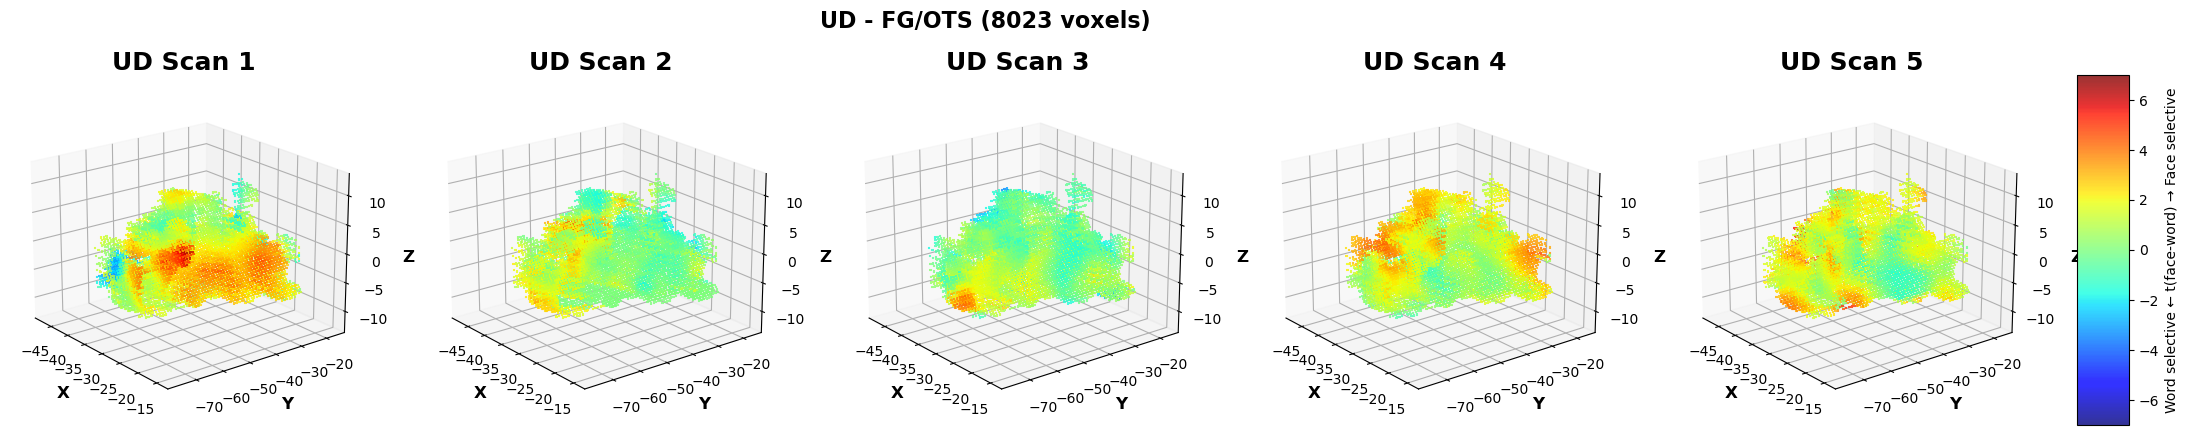

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_LO_PPA_Figure5_replication.png


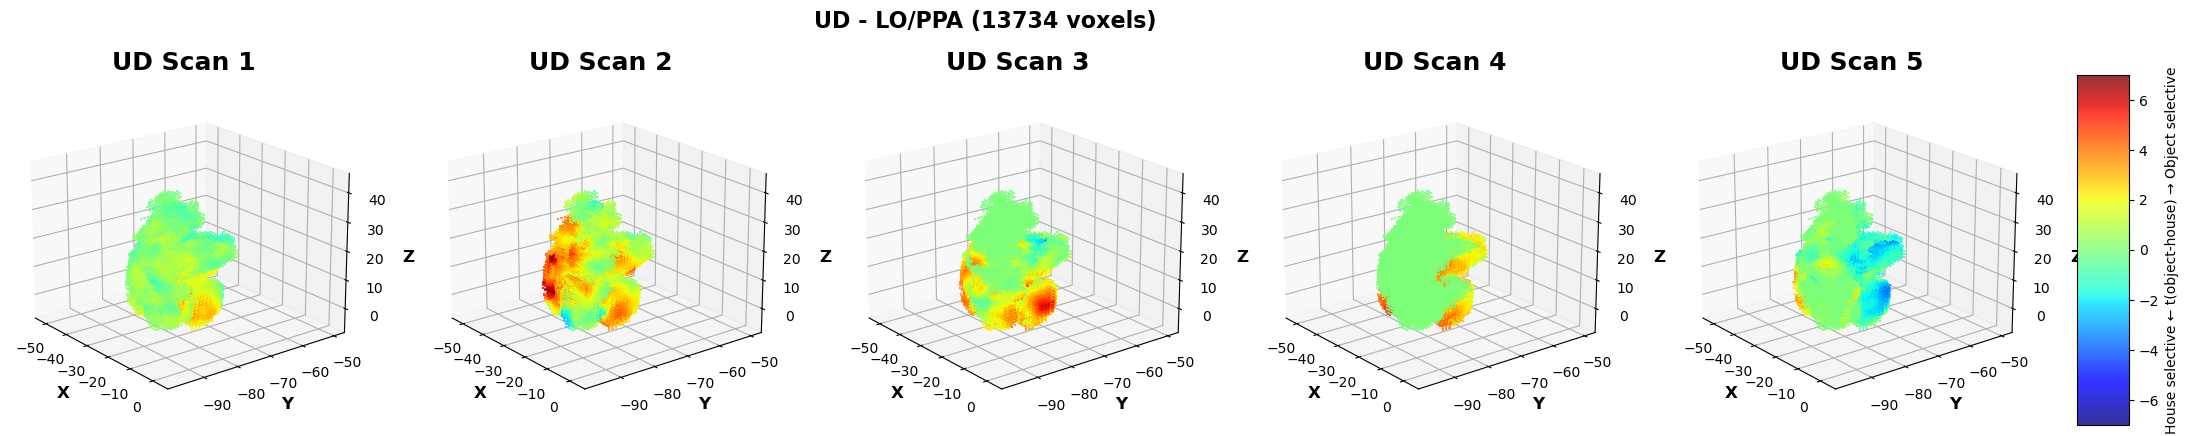

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_FG_OTS_Figure5_replication.png


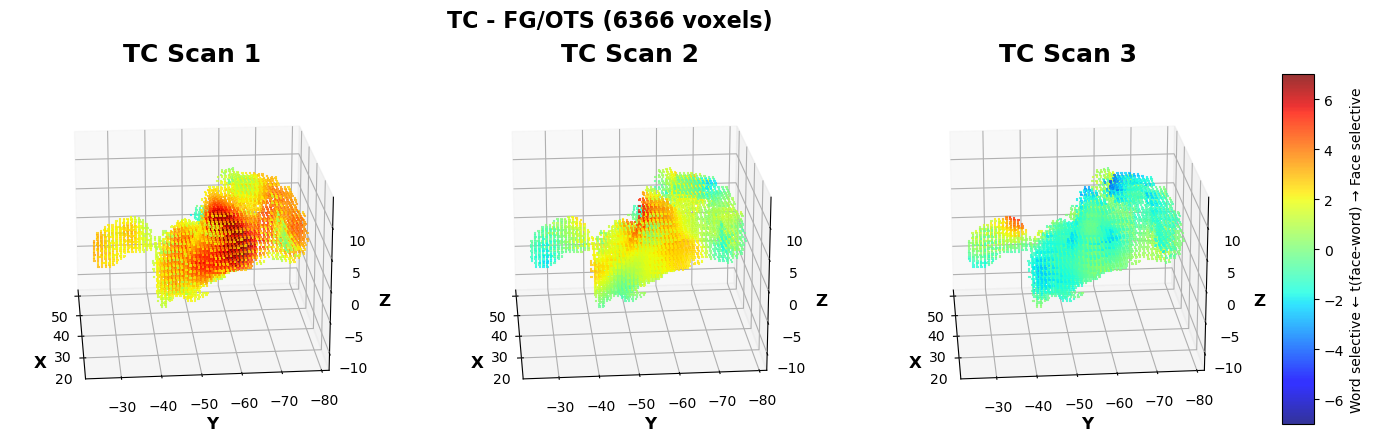

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_LO_PPA_Figure5_replication.png


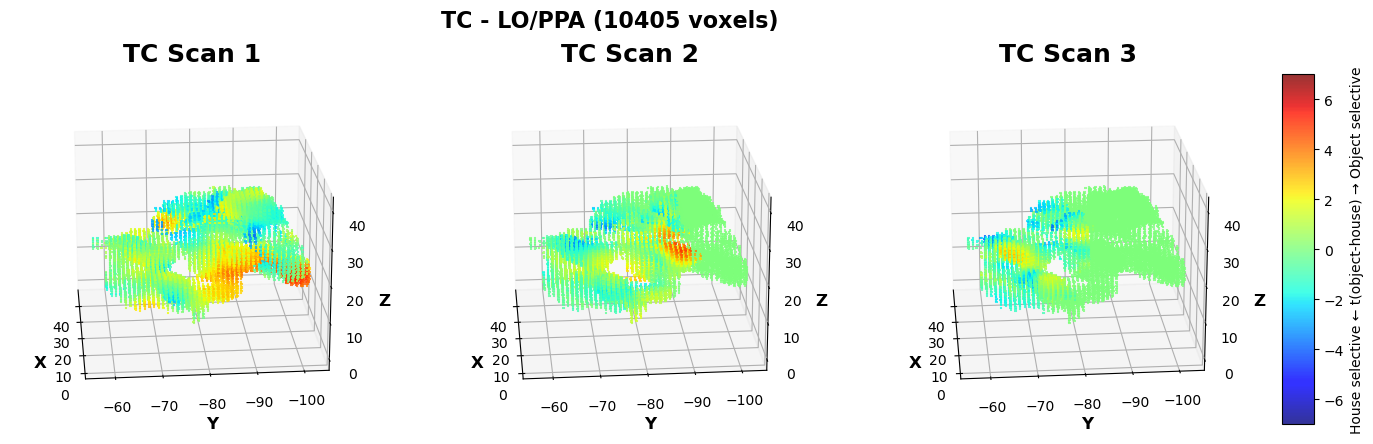

In [22]:
# 2. Create Figure 5 style visualization with dual-cluster ROIs

def create_figure5_liu_style(subject_id, roi_type='face_word', save_path=None):
    """Recreate Liu's Figure 5 with dual-cluster ROI"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    sessions = SUBJECTS[subject_id]['sessions']
    
    # Load all session data
    session_data = {}
    for ses in sessions:
        zstat_file = BASE_DIR / subject_id / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat = nib.load(zstat_file).get_fdata()
            session_data[ses] = zstat[voxel_indices]
    
    # Create figure
    n_sessions = len(session_data)
    fig = plt.figure(figsize=(5*n_sessions + 1, 5))
    
    for idx, ses in enumerate(sorted(session_data.keys())):
        ax = fig.add_subplot(1, n_sessions, idx+1, projection='3d')
        
        t_stats = session_data[ses]
        
        # View angle
        view = (20, 175) if hemi == 'r' else (20, 322)
        
        scatter = ax.scatter(world_coords[:,0], world_coords[:,1], world_coords[:,2],
                           c=t_stats, s=3, marker='+',
                           cmap='jet', vmin=-7, vmax=7, alpha=0.8)
        
        ax.set_xlabel('X', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z', fontsize=12, fontweight='bold')
        ax.set_title(f'{SUBJECTS[subject_id]["code"]} Scan {idx+1}', 
                    fontsize=18, fontweight='bold')
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    # Colorbar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    
    if roi_type == 'face_word':
        cbar.set_label('Word selective ← t(face-word) → Face selective', fontsize=10)
    else:
        cbar.set_label('House selective ← t(object-house) → Object selective', fontsize=10)
    
    roi_label = 'FG/OTS' if roi_type == 'face_word' else 'LO/PPA'
    fig.suptitle(f'{SUBJECTS[subject_id]["code"]} - {roi_label} ({np.sum(roi_mask)} voxels)', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Create visualizations
print("\n" + "="*80)
print("CREATING FIGURE 5 VISUALIZATIONS")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'FG_OTS' if roi_type == 'face_word' else 'LO_PPA'
        save_path = BASE_DIR / 'analyses' / f'{subject_id}_{roi_label}_Figure5_replication.png'
        create_figure5_liu_style(subject_id, roi_type, save_path)

In [25]:
# 3. Summary table comparing to Liu's findings

print("\n" + "="*80)
print("SUMMARY: COMPARISON TO LIU ET AL. FINDINGS")
print("="*80)

print("\nLIU'S FINDING:")
print("  'Significant differences in t(face-word) between any two sessions'")
print("  'EXCEPT for comparisons between scans 1 and 2'")
print()

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} - Face-Word:")
    print("-"*40)
    
    # Get ses-1 vs ses-2 result
    fw_results = stats_results[subject_id]['face_word']
    sessions = sorted(SUBJECTS[subject_id]['sessions'])
    
    ses1_vs_2 = [r for r in fw_results if r['ses1'] == sessions[0] and r['ses2'] == sessions[1]]
    
    if ses1_vs_2:
        r = ses1_vs_2[0]
        print(f"  Scan 1 vs Scan 2: p={r['p']:.4f} {r['sig']}")
        if r['sig'] == 'ns':
            print(f"    ✓ MATCHES Liu (non-significant)")
        else:
            print(f"    ✗ Differs from Liu (significant)")
    
    # Check other comparisons
    other_comparisons = [r for r in fw_results if not (r['ses1'] == sessions[0] and r['ses2'] == sessions[1])]
    n_sig = sum(1 for r in other_comparisons if r['sig'] != 'ns')
    
    print(f"  Other comparisons: {n_sig}/{len(other_comparisons)} significant")
    if n_sig == len(other_comparisons):
        print(f"    ✓ MATCHES Liu (all other comparisons significant)")
    else:
        print(f"    ~ Partial match ({n_sig}/{len(other_comparisons)} significant)")
    
    # Show trajectory
    means_dict = dual_extractions[subject_id]['face_word']['means']
    trajectory = [means_dict[s] for s in sessions if s in means_dict]
    print(f"  Trajectory: {' → '.join([f'{v:.2f}' for v in trajectory])}")

print("\n" + "="*80)


SUMMARY: COMPARISON TO LIU ET AL. FINDINGS

LIU'S FINDING:
  'Significant differences in t(face-word) between any two sessions'
  'EXCEPT for comparisons between scans 1 and 2'


UD - Face-Word:
----------------------------------------
  Scan 1 vs Scan 2: p=0.0000 ***
    ✗ Differs from Liu (significant)
  Other comparisons: 9/9 significant
    ✓ MATCHES Liu (all other comparisons significant)
  Trajectory: 1.62 → 0.47 → 0.29 → 1.27 → 1.45

TC - Face-Word:
----------------------------------------
  Scan 1 vs Scan 2: p=0.0000 ***
    ✗ Differs from Liu (significant)
  Other comparisons: 2/2 significant
    ✓ MATCHES Liu (all other comparisons significant)
  Trajectory: 2.95 → 1.29 → -0.61



In [27]:
# First, create the v2 ROIs with minimum threshold
from scipy import ndimage

def create_dual_cluster_roi_v2(subject_id, roi_type='face_word', 
                               min_threshold=2.3, target_percentile=75):
    """
    Dual-cluster with MINIMUM absolute threshold (z>2.3)
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()} (Dual-Cluster v2)")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope1_name = 6, 'face'
        cope2_num, cope2_name = 9, 'word'
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope1_name = 8, 'object'
        cope2_num, cope2_name = 7, 'house'
    
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # CLUSTER 1 - with minimum threshold
    print(f"\nFinding {cope1_name} cluster (min z>{min_threshold})...")
    roi1_values = cope1_data[anat_mask]
    percentile_thresh1 = np.percentile(roi1_values, target_percentile)
    threshold1 = max(percentile_thresh1, min_threshold)
    
    mask1 = (cope1_data > threshold1) & anat_mask
    labeled1, n_clusters1 = ndimage.label(mask1)
    
    if n_clusters1 > 0:
        cluster_sizes1 = [(labeled1 == i).sum() for i in range(1, n_clusters1 + 1)]
        largest_idx1 = np.argmax(cluster_sizes1) + 1
        cluster1_mask = (labeled1 == largest_idx1)
        n_vox1 = cluster_sizes1[largest_idx1 - 1]
        print(f"  {cope1_name}: {n_vox1} voxels (z>{threshold1:.2f})")
    else:
        cluster1_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox1 = 0
        print(f"  {cope1_name}: No significant clusters found")
    
    # CLUSTER 2 - with minimum threshold
    print(f"Finding {cope2_name} cluster (min z>{min_threshold})...")
    roi2_values = cope2_data[anat_mask]
    percentile_thresh2 = np.percentile(roi2_values, target_percentile)
    threshold2 = max(percentile_thresh2, min_threshold)
    
    mask2 = (cope2_data > threshold2) & anat_mask
    labeled2, n_clusters2 = ndimage.label(mask2)
    
    if n_clusters2 > 0:
        cluster_sizes2 = [(labeled2 == i).sum() for i in range(1, n_clusters2 + 1)]
        largest_idx2 = np.argmax(cluster_sizes2) + 1
        cluster2_mask = (labeled2 == largest_idx2)
        n_vox2 = cluster_sizes2[largest_idx2 - 1]
        print(f"  {cope2_name}: {n_vox2} voxels (z>{threshold2:.2f})")
    else:
        cluster2_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox2 = 0
        print(f"  {cope2_name}: No significant clusters found")
    
    # UNION
    combined_mask = cluster1_mask | cluster2_mask
    n_total = np.sum(combined_mask)
    n_overlap = np.sum(cluster1_mask & cluster2_mask)
    
    print(f"\nCombined ROI: {n_total} voxels")
    if n_total > 0:
        print(f"  {cope1_name} only: {n_vox1 - n_overlap}")
        print(f"  {cope2_name} only: {n_vox2 - n_overlap}")
        print(f"  Overlap: {n_overlap}")
    
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster_v2.nii.gz'
    combined_img = nib.Nifti1Image(combined_mask.astype(np.float32), anat_roi.affine)
    nib.save(combined_img, output_file)
    print(f"  Saved: {output_file}")
    
    return {'mask_file': output_file, 'n_total': n_total}

# Create v2 ROIs
print("CREATING DUAL-CLUSTER V2 ROIs (min z>2.3)")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    create_dual_cluster_roi_v2(subject_id, 'face_word', min_threshold=2.3)
    create_dual_cluster_roi_v2(subject_id, 'object_house', min_threshold=2.3)

CREATING DUAL-CLUSTER V2 ROIs (min z>2.3)

sub-004 - FACE_WORD (Dual-Cluster v2)

Finding face cluster (min z>2.3)...
  face: 1046 voxels (z>2.30)
Finding word cluster (min z>2.3)...
  word: 57 voxels (z>2.30)

Combined ROI: 1103 voxels
  face only: 1046
  word only: 57
  Overlap: 0
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_dual_cluster_v2.nii.gz

sub-004 - OBJECT_HOUSE (Dual-Cluster v2)

Finding object cluster (min z>2.3)...
  object: 2222 voxels (z>2.30)
Finding house cluster (min z>2.3)...
  house: 302 voxels (z>2.30)

Combined ROI: 2524 voxels
  object only: 2222
  house only: 302
  Overlap: 0
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_dual_cluster_v2.nii.gz

sub-021 - FACE_WORD (Dual-Cluster v2)

Finding face cluster (min z>2.3)...
  face: 4476 voxels (z>5.53)
Finding word cluster (min z>2.3)...
  word: 52 voxels (z>2.30)

Combined ROI: 4526 voxels
  face only: 4474
  word only: 50
  Overlap: 2
  Saved: /user_data/csimmon2/lo

In [31]:
# Pairwise t-tests Liu-style (use existing dual_cluster ROIs)

from scipy import stats

def liu_pairwise_ttest(subject_id, roi_type, ses1, ses2):
    """Pairwise comparison of voxel distributions between sessions"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    # Session 1 voxels
    zstat1_file = BASE_DIR / subject_id / f'ses-{ses1}' / 'derivatives' / 'fsl' / 'loc' / \
                  'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
    voxels_ses1 = nib.load(zstat1_file).get_fdata()[voxel_indices]
    
    # Session 2 voxels  
    zstat2_file = BASE_DIR / subject_id / f'ses-{ses2}' / 'derivatives' / 'fsl' / 'loc' / \
                  'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
    voxels_ses2 = nib.load(zstat2_file).get_fdata()[voxel_indices]
    
    # Independent t-test
    t_stat, p_val = stats.ttest_ind(voxels_ses1, voxels_ses2)
    
    return t_stat, p_val, voxels_ses1.mean(), voxels_ses2.mean()

print("="*80)
print("PAIRWISE SESSION COMPARISONS (Liu et al. method)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    print(f"\n{code} - Face-Word:")
    print("-" * 60)
    
    for i in range(len(sessions)-1):
        for j in range(i+1, len(sessions)):
            t, p, m1, m2 = liu_pairwise_ttest(subject_id, 'face_word', sessions[i], sessions[j])
            sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
            print(f"  ses-{sessions[i]} vs ses-{sessions[j]}: t={t:7.2f}, p={p:.4f} {sig:3s} ({m1:.2f} → {m2:.2f})")

PAIRWISE SESSION COMPARISONS (Liu et al. method)

UD - Face-Word:
------------------------------------------------------------
  ses-01 vs ses-02: t=  55.53, p=0.0000 *** (1.62 → 0.47)
  ses-01 vs ses-03: t=  65.60, p=0.0000 *** (1.62 → 0.29)
  ses-01 vs ses-05: t=  16.73, p=0.0000 *** (1.62 → 1.27)
  ses-01 vs ses-06: t=   8.25, p=0.0000 *** (1.62 → 1.45)
  ses-02 vs ses-03: t=  11.01, p=0.0000 *** (0.47 → 0.29)
  ses-02 vs ses-05: t= -44.68, p=0.0000 *** (0.47 → 1.27)
  ses-02 vs ses-06: t= -56.61, p=0.0000 *** (0.47 → 1.45)
  ses-03 vs ses-05: t= -56.37, p=0.0000 *** (0.29 → 1.27)
  ses-03 vs ses-06: t= -68.99, p=0.0000 *** (0.29 → 1.45)
  ses-05 vs ses-06: t= -10.27, p=0.0000 *** (1.27 → 1.45)

TC - Face-Word:
------------------------------------------------------------
  ses-01 vs ses-02: t=  55.05, p=0.0000 *** (2.95 → 1.29)
  ses-01 vs ses-03: t= 125.80, p=0.0000 *** (2.95 → -0.61)
  ses-02 vs ses-03: t=  93.07, p=0.0000 *** (1.29 → -0.61)


METHODS SECTION:
ROI Definition
Category-selective regions of interest (ROIs) were defined in native space for each participant using anatomical and functional constraints. For the fusiform gyrus/occipitotemporal sulcus (FG/OTS) face-word ROI, we first identified the anatomical boundaries of the fusiform gyrus using FreeSurfer's automatic parcellation (aparc) of the structural T1-weighted image. Specifically, we extracted the lateral fusiform label and applied 2 iterations of morphological dilation (fslmaths -dilM) to ensure adequate cortical depth coverage, resulting in anatomical search spaces of approximately 24,000 voxels.
Within these anatomical constraints, we employed a dual-cluster functional localization approach to ensure balanced representation of both face and word selective voxels. For each category (faces and words), we identified the largest cluster of voxels exceeding the 75th percentile of activation values for that category's individual contrast (face>all baseline [cope 6] and word>all baseline [cope 9]) within the anatomical mask. The final ROI was defined as the union of these two clusters, yielding ROIs of 6,000-8,000 voxels for face-word comparisons. An analogous procedure was applied for object-house ROIs using lateral occipital cortex and parahippocampal place area anatomical boundaries, with object>all baseline (cope 8) and house>all baseline (cope 7) contrasts.
Longitudinal Analysis
To examine changes in category selectivity over time, we extracted face-word contrast values (face>word [cope 13]) from each participant's functionally-defined ROI across all available scanning sessions. All functional data were co-registered to the participant's first session structural scan to ensure accurate within-subject spatial correspondence across timepoints.
For statistical comparison between sessions, we performed independent samples t-tests on the voxel-wise contrast value distributions (following Liu et al., 2025), comparing all pairwise combinations of sessions. This voxel-distribution approach tests whether the population of selectivity values differs significantly between timepoints, accounting for the spatial heterogeneity of category representations within each ROI. Statistical significance was determined at p < 0.05 for each pairwise comparison.